# Content
- [Aims](#Aims)
- [Import Data](#Import-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Splitting](#Data-Splitting)
- [Models](#Models)
- [ANOVA](#ANOVA)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)
- [Problems](#Problems)
- [Further Work](#Further-Work)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings('ignore')

# Aims

Construct a linear regression model to interpret how variables affect the average price.

# Helper Functions

In [2]:
def Model_Diagnostic(data, model, date):
    
    model_fitted_y = model.fittedvalues
    standardized_residuals = model.get_influence().resid_studentized_internal
    
    data_time = pd.DataFrame({'Residual': standardized_residuals})
    data_time.index = date
    data_time = data_time.sort_values('Date')
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.hist(standardized_residuals)
    
    plt.subplot(222)
    stats.probplot(standardized_residuals, dist="norm", plot=plt)
    
    plt.subplot(223)
    sns.residplot(model_fitted_y, standardized_residuals,
              lowess=True,
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    
    plt.subplot(224)
    plt.plot(data_time['Residual'].values)
    
    plt.show()

# Import Data

In [3]:
data = pd.read_csv('../../data/Avocado/avocado.csv', index_col = 0)
data.shape

(18249, 13)

In [4]:
data.head()

Date  AveragePrice  Total Volume     4046       4225    4770  \
0  2015-12-27          1.33      64236.62  1036.74   54454.85   48.16   
1  2015-12-20          1.35      54876.98   674.28   44638.81   58.33   
2  2015-12-13          0.93     118220.22   794.70  109149.67  130.50   
3  2015-12-06          1.08      78992.15  1132.00   71976.41   72.58   
4  2015-11-29          1.28      51039.60   941.48   43838.39   75.78   

   Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  region  
0     8696.87     8603.62       93.25          0.0  conventional  2015  Albany  
1     9505.56     9408.07       97.49          0.0  conventional  2015  Albany  
2     8145.35     8042.21      103.14          0.0  conventional  2015  Albany  
3     5811.16     5677.40      133.76          0.0  conventional  2015  Albany  
4     6183.95     5986.26      197.69          0.0  conventional  2015  Albany

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

# Exploratory Data Analysis

In [6]:
data.describe()

AveragePrice  Total Volume          4046          4225          4770  \
count  18249.000000  1.824900e+04  1.824900e+04  1.824900e+04  1.824900e+04   
mean       1.405978  8.506440e+05  2.930084e+05  2.951546e+05  2.283974e+04   
std        0.402677  3.453545e+06  1.264989e+06  1.204120e+06  1.074641e+05   
min        0.440000  8.456000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
25%        1.100000  1.083858e+04  8.540700e+02  3.008780e+03  0.000000e+00   
50%        1.370000  1.073768e+05  8.645300e+03  2.906102e+04  1.849900e+02   
75%        1.660000  4.329623e+05  1.110202e+05  1.502069e+05  6.243420e+03   
max        3.250000  6.250565e+07  2.274362e+07  2.047057e+07  2.546439e+06   

         Total Bags    Small Bags    Large Bags    XLarge Bags          year  
count  1.824900e+04  1.824900e+04  1.824900e+04   18249.000000  18249.000000  
mean   2.396392e+05  1.821947e+05  5.433809e+04    3106.426507   2016.147899  
std    9.862424e+05  7.461785e+05  2.439660e+05   17692.894652      0.939938  
min    0.000000e+00  0.000000e+00  0.000000e+00       0.000000   2015.000000  
25%    5.088640e+03  2.849420e+03  1.274700e+02       0.000000   2015.000000  
50%    3.974383e+04  2.636282e+04  2.647710e+03       0.000000   2016.000000  
75%    1.107834e+05  8.333767e+04  2.202925e+04     132.500000   2017.000000  
max    1.937313e+07  1.338459e+07  5.719097e+06  551693.650000   2018.000000

In [7]:
data.corr()

AveragePrice  Total Volume      4046      4225      4770  \
AveragePrice      1.000000     -0.192752 -0.208317 -0.172928 -0.179446   
Total Volume     -0.192752      1.000000  0.977863  0.974181  0.872202   
4046             -0.208317      0.977863  1.000000  0.926110  0.833389   
4225             -0.172928      0.974181  0.926110  1.000000  0.887855   
4770             -0.179446      0.872202  0.833389  0.887855  1.000000   
Total Bags       -0.177088      0.963047  0.920057  0.905787  0.792314   
Small Bags       -0.174730      0.967238  0.925280  0.916031  0.802733   
Large Bags       -0.172940      0.880640  0.838645  0.810015  0.698471   
XLarge Bags      -0.117592      0.747157  0.699377  0.688809  0.679861   
year              0.093197      0.017193  0.003353 -0.009559 -0.036531   

              Total Bags  Small Bags  Large Bags  XLarge Bags      year  
AveragePrice   -0.177088   -0.174730   -0.172940    -0.117592  0.093197  
Total Volume    0.963047    0.967238    0.880640     0.747157  0.017193  
4046            0.920057    0.925280    0.838645     0.699377  0.003353  
4225            0.905787    0.916031    0.810015     0.688809 -0.009559  
4770            0.792314    0.802733    0.698471     0.679861 -0.036531  
Total Bags      1.000000    0.994335    0.943009     0.804233  0.071552  
Small Bags      0.994335    1.000000    0.902589     0.806845  0.063915  
Large Bags      0.943009    0.902589    1.000000     0.710858  0.087891  
XLarge Bags     0.804233    0.806845    0.710858     1.000000  0.081033  
year            0.071552    0.063915    0.087891     0.081033  1.000000

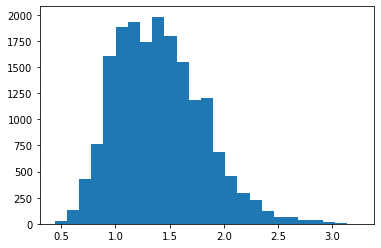

In [8]:
plt.hist(data['AveragePrice'], bins = 25)
plt.show()
# Seems bimodel

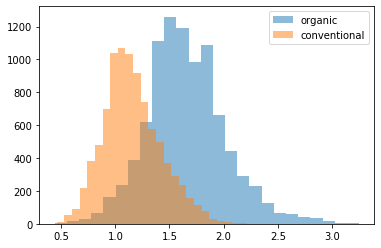

In [9]:
plt.hist(data[data['type'] == 'organic']['AveragePrice'], bins = 25, alpha=0.5, label='organic')
plt.hist(data[data['type'] == 'conventional']['AveragePrice'], bins=25, alpha=0.5, label='conventional')
plt.legend(loc='upper right')
plt.show()

In [10]:
data.groupby('type').mean()['AveragePrice']
# Organic is averagly higher

type
conventional    1.158040
organic         1.653999
Name: AveragePrice, dtype: float64

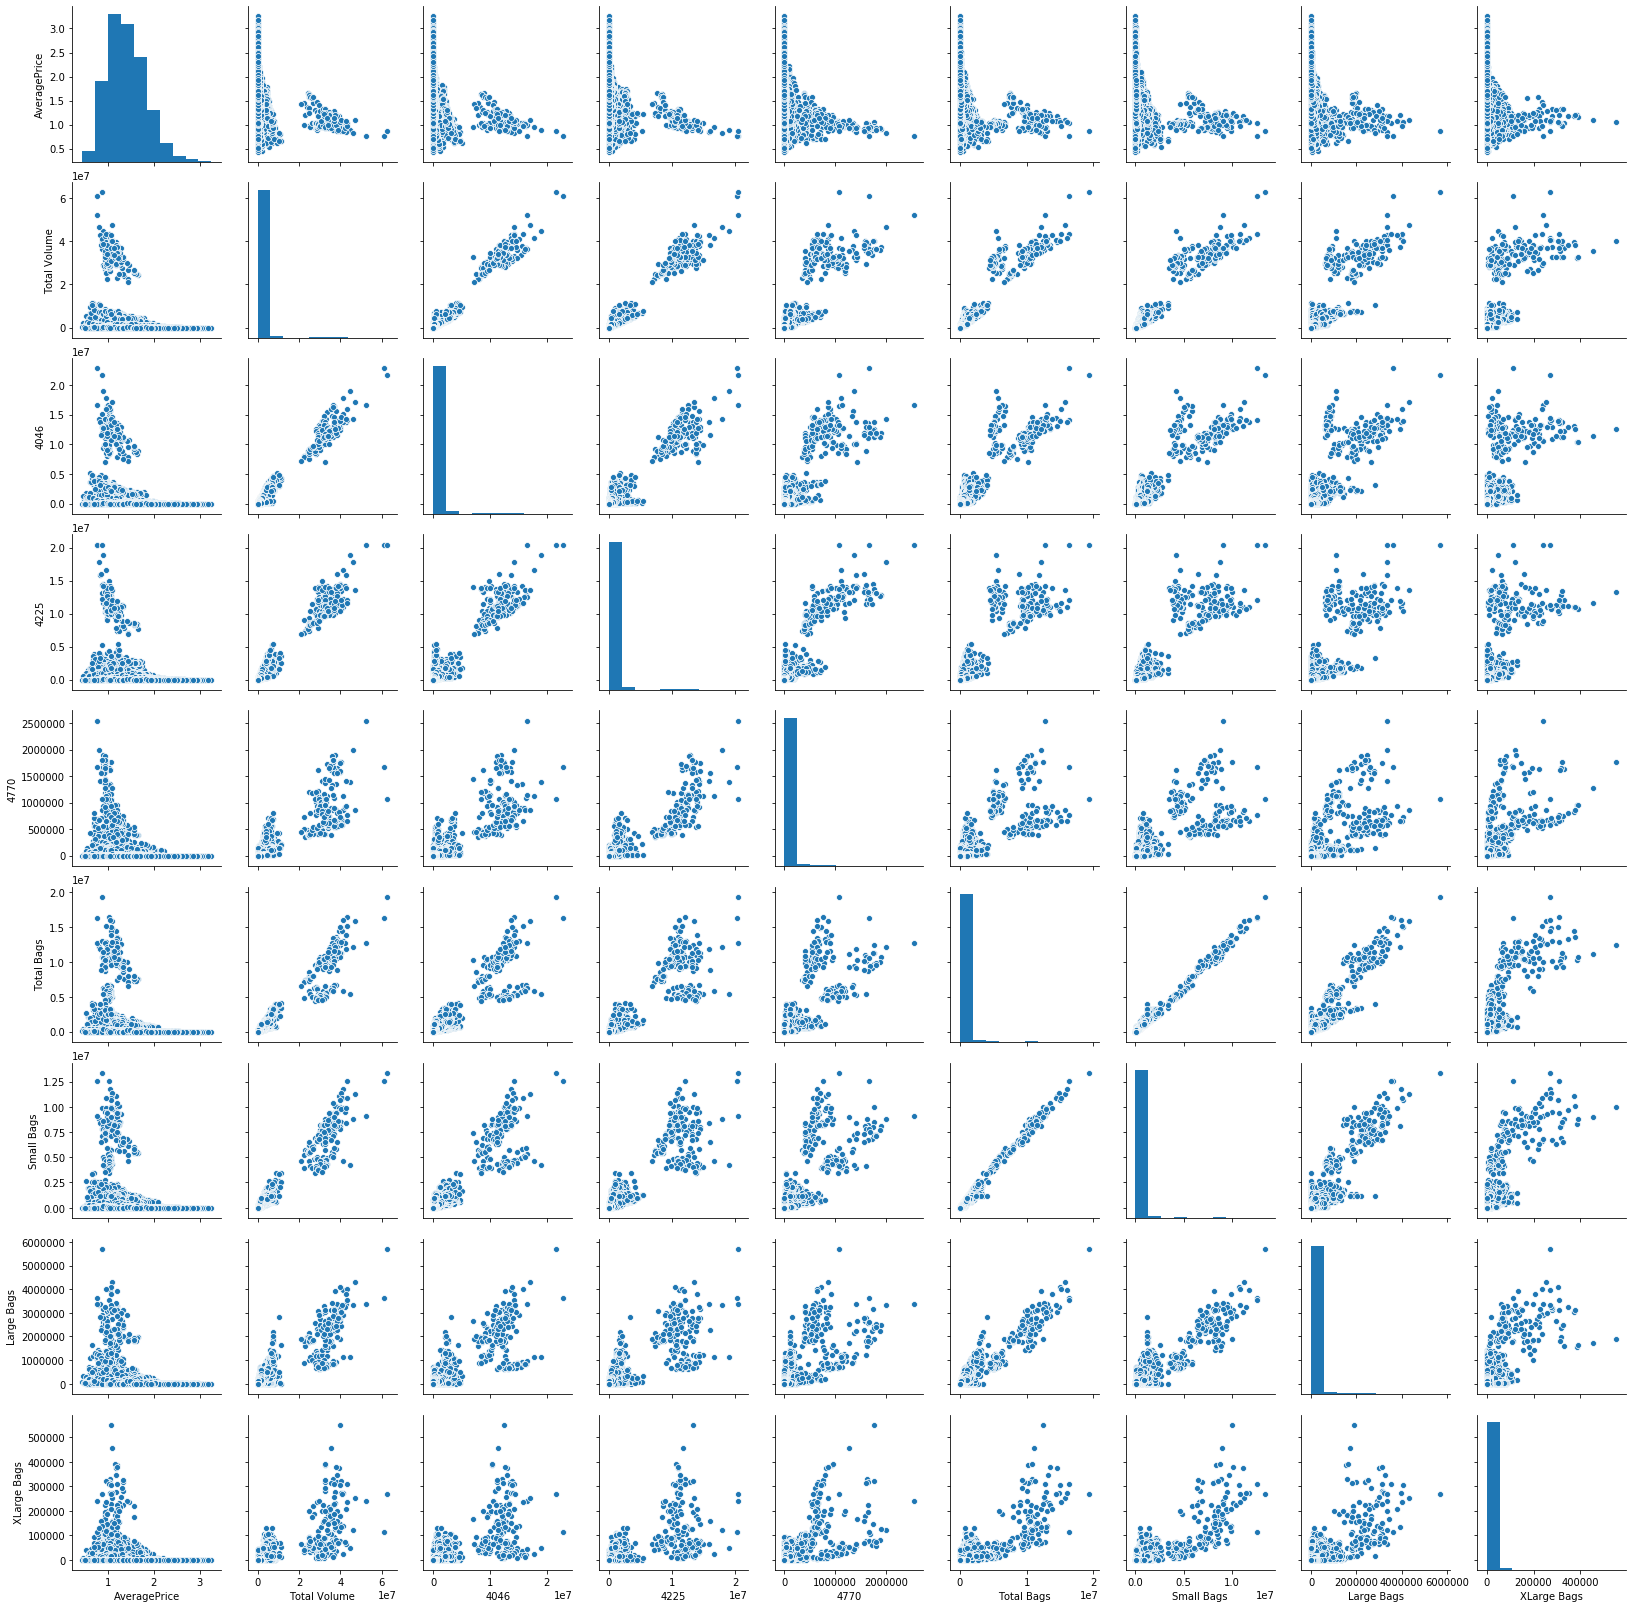

In [11]:
sns.pairplot(data.iloc[:, 1:10])
plt.show()

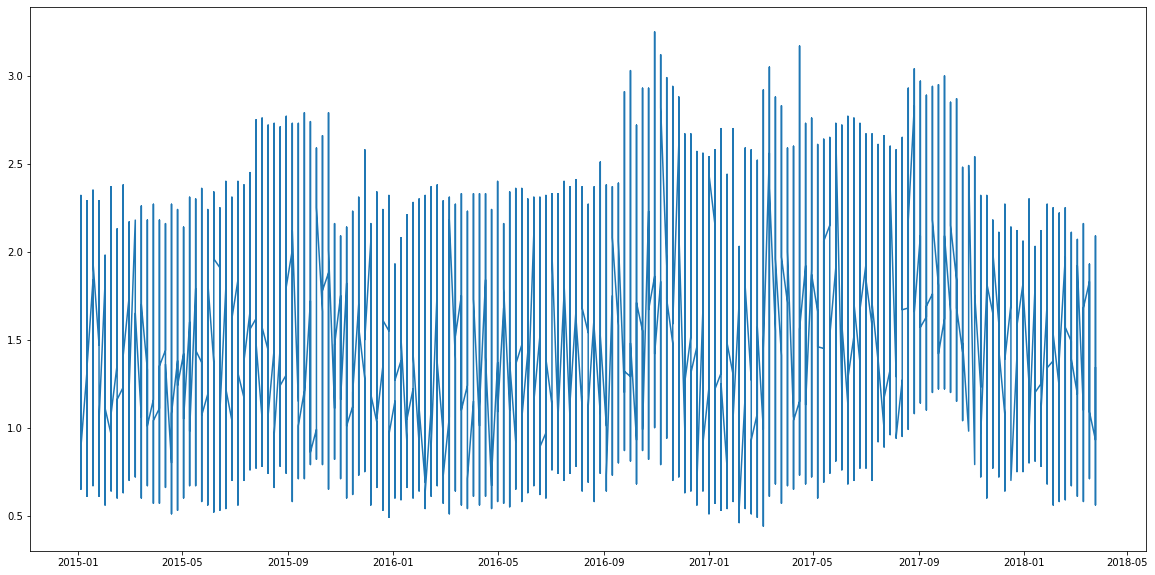

In [12]:
data_time = data[['Date', 'AveragePrice']]
data_time = data.sort_values('Date')

plt.figure(figsize = (20, 10))
plt.plot(data_time['Date'], data_time['AveragePrice'])
plt.show()

# Seem price in September to November is higher.

In [13]:
len(np.unique(data['region']))

54

In [14]:
data['region'].value_counts()

Louisville             338
LasVegas               338
Pittsburgh             338
Houston                338
Jacksonville           338
Albany                 338
West                   338
NewYork                338
Syracuse               338
Midsouth               338
GreatLakes             338
TotalUS                338
Boston                 338
HartfordSpringfield    338
BuffaloRochester       338
Sacramento             338
Roanoke                338
SanFrancisco           338
Plains                 338
SanDiego               338
GrandRapids            338
Detroit                338
BaltimoreWashington    338
HarrisburgScranton     338
Portland               338
Spokane                338
Denver                 338
Orlando                338
NorthernNewEngland     338
LosAngeles             338
RaleighGreensboro      338
Seattle                338
California             338
Tampa                  338
DallasFtWorth          338
NewOrleansMobile       338
SouthCarolina          338
N

In [15]:
data['year'].value_counts()

2017    5722
2016    5616
2015    5615
2018    1296
Name: year, dtype: int64

# Data Splitting

In [16]:
train, test = train_test_split(data, test_size = 0.2, random_state = 0)
train.shape, test.shape

((14599, 13), (3650, 13))

In [17]:
train, validate = train_test_split(train, test_size = 0.3, random_state = 0)
train.shape, validate.shape

((10219, 13), (4380, 13))

# Models 

## Model 1

In [18]:
X = train[['Total Volume', 'Total Bags', 'type', 'region']]
y = train['AveragePrice']

In [19]:
df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)
X.head()

Total Volume  Total Bags            region  organic
47      10657.65     3534.71           Houston        1
6       10754.39     6651.20  CincinnatiDayton        1
46     320492.68   183442.15  CincinnatiDayton        0
39       5611.76      210.41           Spokane        1
27     545889.03   102279.18            Boston        0

In [20]:
df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
X = pd.concat([X, df], axis = 1).drop('region', axis = 1)
X.head()

Total Volume  Total Bags  organic  Albany  Atlanta  BaltimoreWashington  \
47      10657.65     3534.71        1       0        0                    0   
6       10754.39     6651.20        1       0        0                    0   
46     320492.68   183442.15        0       0        0                    0   
39       5611.76      210.41        1       0        0                    0   
27     545889.03   102279.18        0       0        0                    0   

    Boise  Boston  BuffaloRochester  California  ...  SouthCarolina  \
47      0       0                 0           0  ...              0   
6       0       0                 0           0  ...              0   
46      0       0                 0           0  ...              0   
39      0       0                 0           0  ...              0   
27      0       1                 0           0  ...              0   

    SouthCentral  Southeast  Spokane  StLouis  Syracuse  Tampa  TotalUS  West  \
47             0          0        0        0         0      0        0     0   
6              0          0        0        0         0      0        0     0   
46             0          0        0        0         0      0        0     0   
39             0          0        1        0         0      0        0     0   
27             0          0        0        0         0      0        0     0   

    WestTexNewMexico  
47                 0  
6                  0  
46                 0  
39                 0  
27                 0  

[5 rows x 56 columns]

In [21]:
X = X.rename(columns = {'Total Volume': 'Total_Volume', 
                        'Total Bags': 'Total_Bags'})
X.head()

Total_Volume  Total_Bags  organic  Albany  Atlanta  BaltimoreWashington  \
47      10657.65     3534.71        1       0        0                    0   
6       10754.39     6651.20        1       0        0                    0   
46     320492.68   183442.15        0       0        0                    0   
39       5611.76      210.41        1       0        0                    0   
27     545889.03   102279.18        0       0        0                    0   

    Boise  Boston  BuffaloRochester  California  ...  SouthCarolina  \
47      0       0                 0           0  ...              0   
6       0       0                 0           0  ...              0   
46      0       0                 0           0  ...              0   
39      0       0                 0           0  ...              0   
27      0       1                 0           0  ...              0   

    SouthCentral  Southeast  Spokane  StLouis  Syracuse  Tampa  TotalUS  West  \
47             0          0        0        0         0      0        0     0   
6              0          0        0        0         0      0        0     0   
46             0          0        0        0         0      0        0     0   
39             0          0        1        0         0      0        0     0   
27             0          0        0        0         0      0        0     0   

    WestTexNewMexico  
47                 0  
6                  0  
46                 0  
39                 0  
27                 0  

[5 rows x 56 columns]

In [22]:
X['Total_Volume_organic'] = X['Total_Volume'] * X['organic']
X['Total_Bags_organic'] = X['Total_Bags'] * X['organic']
X.head()

Total_Volume  Total_Bags  organic  Albany  Atlanta  BaltimoreWashington  \
47      10657.65     3534.71        1       0        0                    0   
6       10754.39     6651.20        1       0        0                    0   
46     320492.68   183442.15        0       0        0                    0   
39       5611.76      210.41        1       0        0                    0   
27     545889.03   102279.18        0       0        0                    0   

    Boise  Boston  BuffaloRochester  California  ...  Southeast  Spokane  \
47      0       0                 0           0  ...          0        0   
6       0       0                 0           0  ...          0        0   
46      0       0                 0           0  ...          0        0   
39      0       0                 0           0  ...          0        1   
27      0       1                 0           0  ...          0        0   

    StLouis  Syracuse  Tampa  TotalUS  West  WestTexNewMexico  \
47        0         0      0        0     0                 0   
6         0         0      0        0     0                 0   
46        0         0      0        0     0                 0   
39        0         0      0        0     0                 0   
27        0         0      0        0     0                 0   

    Total_Volume_organic  Total_Bags_organic  
47              10657.65             3534.71  
6               10754.39             6651.20  
46                  0.00                0.00  
39               5611.76              210.41  
27                  0.00                0.00  

[5 rows x 58 columns]

In [23]:
for region in train['region'].unique():
    if region != 'HarrisburgScranton':
        col_name = 'Total_Volume' + '_' + region
        X[col_name] = X['Total_Volume'] * X[region]
        col_name = 'Total_Bags' + '_' + region
        X[col_name] = X['Total_Bags'] * X[region]
        col_name = 'organic' + '_' + region
        X[col_name] = X['organic'] * X[region]
        col_name = 'Total_Volume' + '_' + 'organic' + '_' + region
        X[col_name] = X['Total_Volume'] * X['organic'] * X[region]
        col_name = 'Total_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Total_Bags'] * X['organic'] * X[region]

In [24]:
X.head()

Total_Volume  Total_Bags  organic  Albany  Atlanta  BaltimoreWashington  \
47      10657.65     3534.71        1       0        0                    0   
6       10754.39     6651.20        1       0        0                    0   
46     320492.68   183442.15        0       0        0                    0   
39       5611.76      210.41        1       0        0                    0   
27     545889.03   102279.18        0       0        0                    0   

    Boise  Boston  BuffaloRochester  California  ...  Total_Volume_Midsouth  \
47      0       0                 0           0  ...                    0.0   
6       0       0                 0           0  ...                    0.0   
46      0       0                 0           0  ...                    0.0   
39      0       0                 0           0  ...                    0.0   
27      0       1                 0           0  ...                    0.0   

    Total_Bags_Midsouth  organic_Midsouth  Total_Volume_organic_Midsouth  \
47                  0.0                 0                            0.0   
6                   0.0                 0                            0.0   
46                  0.0                 0                            0.0   
39                  0.0                 0                            0.0   
27                  0.0                 0                            0.0   

    Total_Bags_organic_Midsouth  Total_Volume_Indianapolis  \
47                          0.0                        0.0   
6                           0.0                        0.0   
46                          0.0                        0.0   
39                          0.0                        0.0   
27                          0.0                        0.0   

    Total_Bags_Indianapolis  organic_Indianapolis  \
47                      0.0                     0   
6                       0.0                     0   
46                      0.0                     0   
39                      0.0                     0   
27                      0.0                     0   

    Total_Volume_organic_Indianapolis  Total_Bags_organic_Indianapolis  
47                                0.0                              0.0  
6                                 0.0                              0.0  
46                                0.0                              0.0  
39                                0.0                              0.0  
27                                0.0                              0.0  

[5 rows x 323 columns]

In [25]:
model_1 = sm.OLS(y, sm.add_constant(X)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           AveragePrice   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     85.66
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        09:59:55   Log-Likelihood:                 1698.5
No. Observations:               10219   AIC:                            -2749.
Df Residuals:                    9895   BIC:                            -405.8
Df Model:                         323                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                        1.5906      0.122     12.994      0.000       1.351       1.831
Total_Volume                              -2.18e-06   6.48e-07     -3.364      0.001   -3.45e-06    -9.1e-07
Total_Bags                                2.618e-06   1.75e-06      1.495      0.135   -8.14e-07    6.05e-06
organic                                      0.3278      0.128      2.553      0.011       0.076       0.580
Albany                                      -0.1489      0.144     -1.034      0.301      -0.431       0.133
Atlanta                                      0.0437      0.165      0.265      0.791      -0.279       0.367
BaltimoreWashington                          0.1596      0.179      0.891      0.373      -0.192       0.511
Boise                                       -0.1475      0.166     -0.889      0.374      -0.473       0.178
Boston                                       0.0316      0.178      0.178      0.859      -0.316       0.380
BuffaloRochester                             0.0029      0.162      0.018      0.986      -0.314       0.320
California                                   0.2460      0.165      1.493      0.135      -0.077       0.569
Charlotte                                    0.0339      0.162      0.209      0.834      -0.284       0.352
Chicago                                      0.7842      0.159      4.942      0.000       0.473       1.095
CincinnatiDayton                             0.0533      0.173      0.307      0.759      -0.286       0.393
Columbus                                     0.0205      0.156      0.132      0.895      -0.285       0.326
DallasFtWorth                               -0.0848      0.194     -0.437      0.662      -0.465       0.296
Denver                                       0.2049      0.175      1.171      0.242      -0.138       0.548
Detroit                                      0.0977      0.149      0.657      0.511      -0.194       0.389
GrandRapids                                  0.3236      0.155      2.091      0.037       0.020       0.627
GreatLakes                                   0.1108      0.157      0.705      0.481      -0.197       0.419
HartfordSpringfield                          0.1614      0.174      0.929      0.353      -0.179       0.502
Houston                                     -0.1577      0.173     -0.913      0.361      -0.496       0.181
Indianapolis                                 0.3136      0.173      1.816      0.069      -0.025       0.652
Jacksonville                             -5.606e-06      0.141  -3.98e-05      1.000      -0.276       0.276
LasVegas                                     0.0836      0.175      0.479      0.632      -0.259       0.426
LosAngeles                     

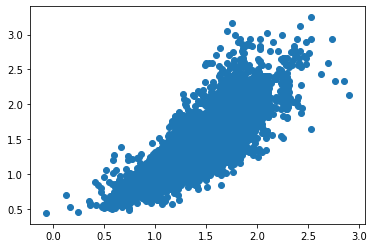

In [26]:
plt.scatter(model_1.fittedvalues, y)
plt.show()

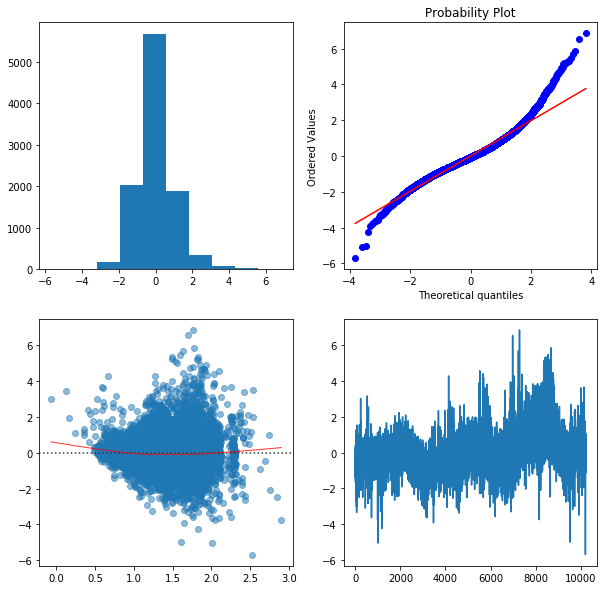

In [27]:
Model_Diagnostic(data = X, model = model_1, date = train['Date'])
# Curved and increasing variance
# A bit right-skewed
# Increasing with time

## Model 2

In [28]:
(train['Total Volume'] <= 0).sum()

0

In [29]:
(train['Total Bags'] <= 0).sum()

7

In [30]:
(train['AveragePrice'] <= 0).sum()

0

In [31]:
X = train[['Total Volume', 'Total Bags', 'type', 'region']]
y = train['AveragePrice']

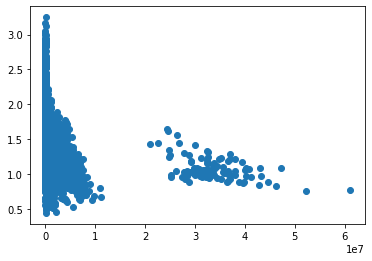

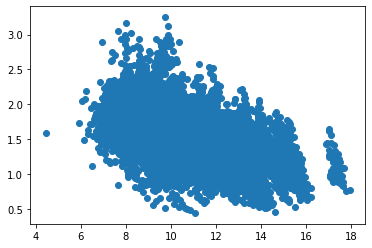

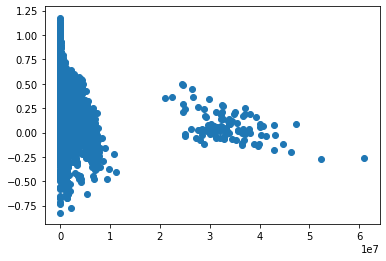

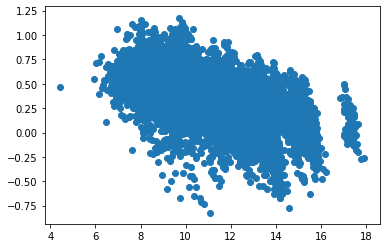

In [32]:
plt.scatter(X['Total Volume'], y)
plt.show()

plt.scatter(np.log(X['Total Volume']), y)
plt.show()

plt.scatter(X['Total Volume'], np.log(y))
plt.show()

plt.scatter(np.log(X['Total Volume']), np.log(y))
plt.show()

In [33]:
X['log_Total_Volume'] = np.log(X['Total Volume'])
X = X.drop('Total Volume', axis = 1)
X.head()

Total Bags          type            region  log_Total_Volume
47     3534.71       organic           Houston          9.274033
6      6651.20       organic  CincinnatiDayton          9.283069
46   183442.15  conventional  CincinnatiDayton         12.677615
39      210.41       organic           Spokane          8.632620
27   102279.18  conventional            Boston         13.210171

In [34]:
y = np.log(y)
y = y.rename('log_AveragePrice', axis = 1)

In [35]:
df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

X = X.rename(columns = {'Total Bags': 'Total_Bags'})

X['log_Total_Volume_organic'] = X['log_Total_Volume'] * X['organic']
X['Total_Bags_organic'] = X['Total_Bags'] * X['organic']

for region in train['region'].unique():
    if region != 'HarrisburgScranton':
        col_name = 'log_Total_Volume' + '_' + region
        X[col_name] = X['log_Total_Volume'] * X[region]
        col_name = 'Total_Bags' + '_' + region
        X[col_name] = X['Total_Bags'] * X[region]
        col_name = 'organic' + '_' + region
        X[col_name] = X['organic'] * X[region]
        col_name = 'log_Total_Volume' + '_' + 'organic' + '_' + region
        X[col_name] = X['log_Total_Volume'] * X['organic'] * X[region]
        col_name = 'Total_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Total_Bags'] * X['organic'] * X[region]

In [36]:
X.head()

Total_Bags  log_Total_Volume  organic  Albany  Atlanta  \
47     3534.71          9.274033        1       0        0   
6      6651.20          9.283069        1       0        0   
46   183442.15         12.677615        0       0        0   
39      210.41          8.632620        1       0        0   
27   102279.18         13.210171        0       0        0   

    BaltimoreWashington  Boise  Boston  BuffaloRochester  California  ...  \
47                    0      0       0                 0           0  ...   
6                     0      0       0                 0           0  ...   
46                    0      0       0                 0           0  ...   
39                    0      0       0                 0           0  ...   
27                    0      0       1                 0           0  ...   

    log_Total_Volume_Midsouth  Total_Bags_Midsouth  organic_Midsouth  \
47                        0.0                  0.0                 0   
6                         0.0                  0.0                 0   
46                        0.0                  0.0                 0   
39                        0.0                  0.0                 0   
27                        0.0                  0.0                 0   

    log_Total_Volume_organic_Midsouth  Total_Bags_organic_Midsouth  \
47                                0.0                          0.0   
6                                 0.0                          0.0   
46                                0.0                          0.0   
39                                0.0                          0.0   
27                                0.0                          0.0   

    log_Total_Volume_Indianapolis  Total_Bags_Indianapolis  \
47                            0.0                      0.0   
6                             0.0                      0.0   
46                            0.0                      0.0   
39                            0.0                      0.0   
27                            0.0                      0.0   

    organic_Indianapolis  log_Total_Volume_organic_Indianapolis  \
47                     0                                    0.0   
6                      0                                    0.0   
46                     0                                    0.0   
39                     0                                    0.0   
27                     0                                    0.0   

    Total_Bags_organic_Indianapolis  
47                              0.0  
6                               0.0  
46                              0.0  
39                              0.0  
27                              0.0  

[5 rows x 323 columns]

In [37]:
model_2 = sm.OLS(y, sm.add_constant(X)).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_AveragePrice   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     103.3
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:02:29   Log-Likelihood:                 5747.8
No. Observations:               10219   AIC:                        -1.085e+04
Df Residuals:                    9895   BIC:                            -8504.
Df Model:                         323                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                            5.4083      1.270      4.257      0.000       2.918       7.898
Total_Bags                                    2.382e-06   1.19e-06      1.996      0.046    4.28e-08    4.72e-06
log_Total_Volume                                -0.4332      0.107     -4.045      0.000      -0.643      -0.223
organic                                         -5.3256      1.326     -4.017      0.000      -7.925      -2.727
Albany                                          -4.5404      1.389     -3.268      0.001      -7.264      -1.817
Atlanta                                          3.9295      1.844      2.131      0.033       0.315       7.544
BaltimoreWashington                              5.2416      1.819      2.882      0.004       1.677       8.807
Boise                                           -3.4044      1.666     -2.044      0.041      -6.670      -0.139
Boston                                          -0.0840      1.658     -0.051      0.960      -3.334       3.166
BuffaloRochester                                -3.9029      1.948     -2.004      0.045      -7.721      -0.085
California                                       6.5791      1.882      3.495      0.000       2.890      10.269
Charlotte                                       -0.0521      1.770     -0.029      0.977      -3.522       3.418
Chicago                                          6.1819      1.615      3.829      0.000       3.017       9.347
CincinnatiDayton                                 3.1715      1.824      1.739      0.082      -0.404       6.747
Columbus                                         2.0565      1.647      1.248      0.212      -1.172       5.285
DallasFtWorth                                    5.9612      1.992      2.992      0.003       2.056       9.866
Denver                                           4.5901      1.883      2.438      0.015       0.899       8.281
Detroit                                          3.0941      1.540      2.009      0.045       0.075       6.113
GrandRapids                                      1.7959      1.403      1.280      0.200      -0.954       4.546
GreatLakes                                       6.3615      1.848      3.443      0.001       2.740       9.983
HartfordSpringfield                              0.7585      1.543      0.491      0.623      -2.267       3.784
Houston                                          7.6880      1.871      4.109      0.000       4.021      11.355
Indianapolis                                     3.8216      1.760      2.171      0.030       0.371       7.272
Jacksonville                                    -0.0253      1.648     -0.015      0.988      -3.256       3.205
LasVegas                        

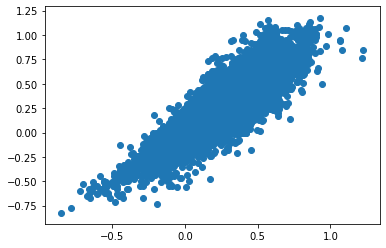

In [38]:
plt.scatter(model_2.fittedvalues, y)
plt.show()

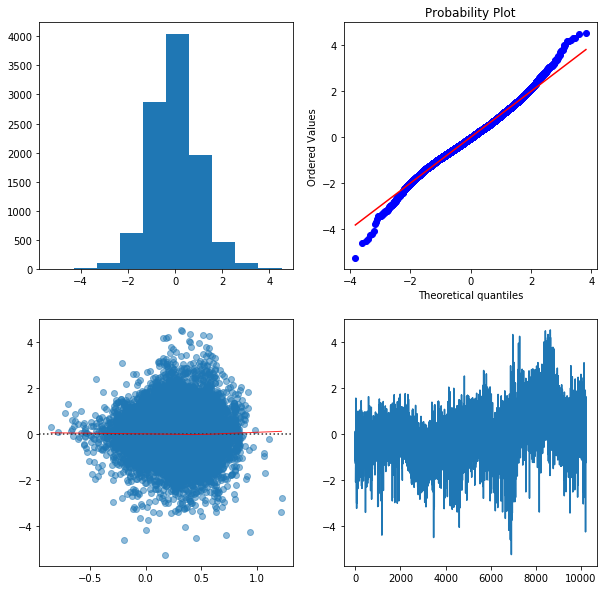

In [39]:
Model_Diagnostic(data = X, model = model_2, date = train['Date'])
# Much more normal
# Still increasing variance
# Increasing with time

In [40]:
SSE = np.sum((np.exp(y) - np.exp(model_2.fittedvalues))**2)
SST = np.sum((np.exp(y) - np.mean(np.exp(y)))**2)
1-(SSE/(X.shape[0] - X.shape[1] - 1))/(SST/(X.shape[0] - 1))
# Although model 1 has a higher adjusted r-squared, the qq plot of model 2 looks more normal. We choose model 2 instead.

0.7277799333069841

## Model 3

We observed that the price will tend to be higher from September to November. Now we added one more variable 'season' to see if it can help explain the variation of price.

In [41]:
X = train[['Total Volume', 'Total Bags', 'type', 'region', 'Date']]
y = train['AveragePrice']

In [42]:
X['log_Total_Volume'] = np.log(X['Total Volume'])
X = X.drop('Total Volume', axis = 1)

X = X.rename(columns = {'Total Bags': 'Total_Bags'})

y = np.log(y)
y = y.rename('log_AveragePrice', axis = 1)

df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

In [43]:
X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
               'Summer' if (x == 6 or x == 7 or x == 8) else
               'Autumn' if (x == 9 or x == 10 or x == 11) else
               'Winter' for x in pd.DatetimeIndex(X['Date']).month]
X = X.drop('Date', axis = 1)
X.head()

Total_Bags  log_Total_Volume  organic  Albany  Atlanta  \
47     3534.71          9.274033        1       0        0   
6      6651.20          9.283069        1       0        0   
46   183442.15         12.677615        0       0        0   
39      210.41          8.632620        1       0        0   
27   102279.18         13.210171        0       0        0   

    BaltimoreWashington  Boise  Boston  BuffaloRochester  California  ...  \
47                    0      0       0                 0           0  ...   
6                     0      0       0                 0           0  ...   
46                    0      0       0                 0           0  ...   
39                    0      0       0                 0           0  ...   
27                    0      0       1                 0           0  ...   

    SouthCentral  Southeast  Spokane  StLouis  Syracuse  Tampa  TotalUS  West  \
47             0          0        0        0         0      0        0     0   
6              0          0        0        0         0      0        0     0   
46             0          0        0        0         0      0        0     0   
39             0          0        1        0         0      0        0     0   
27             0          0        0        0         0      0        0     0   

    WestTexNewMexico  season  
47                 0  Winter  
6                  0  Winter  
46                 0  Winter  
39                 0  Spring  
27                 0  Summer  

[5 rows x 57 columns]

In [44]:
df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
X = pd.concat([X, df], axis = 1).drop('season', axis = 1)
X.head()

Total_Bags  log_Total_Volume  organic  Albany  Atlanta  \
47     3534.71          9.274033        1       0        0   
6      6651.20          9.283069        1       0        0   
46   183442.15         12.677615        0       0        0   
39      210.41          8.632620        1       0        0   
27   102279.18         13.210171        0       0        0   

    BaltimoreWashington  Boise  Boston  BuffaloRochester  California  ...  \
47                    0      0       0                 0           0  ...   
6                     0      0       0                 0           0  ...   
46                    0      0       0                 0           0  ...   
39                    0      0       0                 0           0  ...   
27                    0      0       1                 0           0  ...   

    Spokane  StLouis  Syracuse  Tampa  TotalUS  West  WestTexNewMexico  \
47        0        0         0      0        0     0                 0   
6         0        0         0      0        0     0                 0   
46        0        0         0      0        0     0                 0   
39        1        0         0      0        0     0                 0   
27        0        0         0      0        0     0                 0   

    Autumn  Spring  Summer  
47       0       0       0  
6        0       0       0  
46       0       0       0  
39       0       1       0  
27       0       0       1  

[5 rows x 59 columns]

In [45]:
X['log_Total_Volume_organic'] = X['log_Total_Volume'] * X['organic']
X['Total_Bags_organic'] = X['Total_Bags'] * X['organic']

In [46]:
for season in ['Spring', 'Summer', 'Autumn']:
    col_name = 'log_Total_Volume' + '_' + season
    X[col_name] = X['log_Total_Volume'] * X[season]
    col_name = 'Total_Bags' + '_' + season
    X[col_name] = X['Total_Bags'] * X[season]
    col_name = 'organic' + '_' + season
    X[col_name] = X['organic'] * X[season]
    col_name = 'log_Total_Volume' + '_' + 'organic' + '_' + season
    X[col_name] = X['log_Total_Volume'] * X['organic'] * X[season]
    col_name = 'Total_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Total_Bags'] * X['organic'] * X[season]

In [47]:
X.head()

Total_Bags  log_Total_Volume  organic  Albany  Atlanta  \
47     3534.71          9.274033        1       0        0   
6      6651.20          9.283069        1       0        0   
46   183442.15         12.677615        0       0        0   
39      210.41          8.632620        1       0        0   
27   102279.18         13.210171        0       0        0   

    BaltimoreWashington  Boise  Boston  BuffaloRochester  California  ...  \
47                    0      0       0                 0           0  ...   
6                     0      0       0                 0           0  ...   
46                    0      0       0                 0           0  ...   
39                    0      0       0                 0           0  ...   
27                    0      0       1                 0           0  ...   

    log_Total_Volume_Summer  Total_Bags_Summer  organic_Summer  \
47                 0.000000               0.00               0   
6                  0.000000               0.00               0   
46                 0.000000               0.00               0   
39                 0.000000               0.00               0   
27                13.210171          102279.18               0   

    log_Total_Volume_organic_Summer  Total_Bags_organic_Summer  \
47                              0.0                        0.0   
6                               0.0                        0.0   
46                              0.0                        0.0   
39                              0.0                        0.0   
27                              0.0                        0.0   

    log_Total_Volume_Autumn  Total_Bags_Autumn  organic_Autumn  \
47                      0.0                0.0               0   
6                       0.0                0.0               0   
46                      0.0                0.0               0   
39                      0.0                0.0               0   
27                      0.0                0.0               0   

    log_Total_Volume_organic_Autumn  Total_Bags_organic_Autumn  
47                              0.0                        0.0  
6                               0.0                        0.0  
46                              0.0                        0.0  
39                              0.0                        0.0  
27                              0.0                        0.0  

[5 rows x 76 columns]

In [48]:
for region in train['region'].unique():
    if region != 'HarrisburgScranton':
        col_name = 'log_Total_Volume' + '_' + region
        X[col_name] = X['log_Total_Volume'] * X[region]
        col_name = 'Total_Bags' + '_' + region
        X[col_name] = X['Total_Bags'] * X[region]
        col_name = 'organic' + '_' + region
        X[col_name] = X['organic'] * X[region]
        col_name = 'log_Total_Volume' + '_' + 'organic' + '_' + region
        X[col_name] = X['log_Total_Volume'] * X['organic'] * X[region]
        col_name = 'Total_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Total_Bags'] * X['organic'] * X[region]
        for season in ['Spring', 'Summer', 'Autumn']:
            col_name = region + '_' + season
            X[col_name] = X[region] * X[season]
            col_name = 'log_Total_Volume' + '_' + region + '_' + season
            X[col_name] = X['log_Total_Volume'] * X[region] * X[season]
            col_name = 'Total_Bags' + '_' + region + '_' + season
            X[col_name] = X['Total_Bags'] * X[region] * X[season]
            col_name = 'organic' + '_' + region + '_' + season
            X[col_name] = X['organic'] * X[region] * X[season]
            col_name = 'log_Total_Volume' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['log_Total_Volume'] * X['organic'] * X[region] * X[season]
            col_name = 'Total_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Total_Bags'] * X['organic'] * X[region] * X[season]

In [49]:
X.head()

Total_Bags  log_Total_Volume  organic  Albany  Atlanta  \
47     3534.71          9.274033        1       0        0   
6      6651.20          9.283069        1       0        0   
46   183442.15         12.677615        0       0        0   
39      210.41          8.632620        1       0        0   
27   102279.18         13.210171        0       0        0   

    BaltimoreWashington  Boise  Boston  BuffaloRochester  California  ...  \
47                    0      0       0                 0           0  ...   
6                     0      0       0                 0           0  ...   
46                    0      0       0                 0           0  ...   
39                    0      0       0                 0           0  ...   
27                    0      0       1                 0           0  ...   

    Total_Bags_Indianapolis_Summer  organic_Indianapolis_Summer  \
47                             0.0                            0   
6                              0.0                            0   
46                             0.0                            0   
39                             0.0                            0   
27                             0.0                            0   

    log_Total_Volume_organic_Indianapolis_Summer  \
47                                           0.0   
6                                            0.0   
46                                           0.0   
39                                           0.0   
27                                           0.0   

    Total_Bags_organic_Indianapolis_Summer  Indianapolis_Autumn  \
47                                     0.0                    0   
6                                      0.0                    0   
46                                     0.0                    0   
39                                     0.0                    0   
27                                     0.0                    0   

    log_Total_Volume_Indianapolis_Autumn  Total_Bags_Indianapolis_Autumn  \
47                                   0.0                             0.0   
6                                    0.0                             0.0   
46                                   0.0                             0.0   
39                                   0.0                             0.0   
27                                   0.0                             0.0   

    organic_Indianapolis_Autumn  log_Total_Volume_organic_Indianapolis_Autumn  \
47                            0                                           0.0   
6                             0                                           0.0   
46                            0                                           0.0   
39                            0                                           0.0   
27                            0                                           0.0   

    Total_Bags_organic_Indianapolis_Autumn  
47                                     0.0  
6                                      0.0  
46                                     0.0  
39                                     0.0  
27                                     0.0  

[5 rows x 1295 columns]

In [50]:
model_3 = sm.OLS(y, sm.add_constant(X)).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_AveragePrice   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     35.77
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:04:23   Log-Likelihood:                 7524.9
No. Observations:               10219   AIC:                        -1.246e+04
Df Residuals:                    8923   BIC:                            -3085.
Df Model:                        1295                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
const                                                   2.2816      1.869      1.221      0.222      -1.382       5.945
Total_Bags                                          -2.352e-07   2.69e-06     -0.087      0.930   -5.51e-06    5.04e-06
log_Total_Volume                                       -0.1681      0.160     -1.053      0.293      -0.481       0.145
organic                                                -2.8264      2.201     -1.284      0.199      -7.141       1.488
Albany                                                 -0.8319      2.083     -0.399      0.690      -4.914       3.251
Atlanta                                                 2.4777      3.035      0.816      0.414      -3.472       8.427
BaltimoreWashington                                     3.4048      2.632      1.294      0.196      -1.754       8.563
Boise                                                  -2.5438      2.683     -0.948      0.343      -7.804       2.716
Boston                                                 -0.7881      2.368     -0.333      0.739      -5.430       3.853
BuffaloRochester                                        1.0286      2.878      0.357      0.721      -4.614       6.671
California                                              2.0218      2.771      0.730      0.466      -3.410       7.454
Charlotte                                               1.7499      2.316      0.755      0.450      -2.791       6.291
Chicago                                                 5.8753      2.560      2.295      0.022       0.858      10.893
CincinnatiDayton                                        4.4442      2.749      1.617      0.106      -0.945       9.833
Columbus                                                2.0363      2.391      0.852      0.394      -2.650       6.723
DallasFtWorth                                           5.8008      3.306      1.754      0.079      -0.681      12.282
Denver                                                  6.3941      3.055      2.093      0.036       0.406      12.382
Detroit                                                 3.1887      2.499      1.276      0.202      -1.710       8.087
GrandRapids                                             2.7222      2.054      1.325      0.185      -1.305       6.749
GreatLakes                                              5.6171      2.842      1.976      0.048       0.046      11.188
HartfordSpringfield                                     2.1930      2.189      1.002      0.317      -2.099       6.485
Houston                                                 9.1086      2.732      3.334      0.001       3.753      14.464
Indianapolis                                            4.6697      2.706      1.72

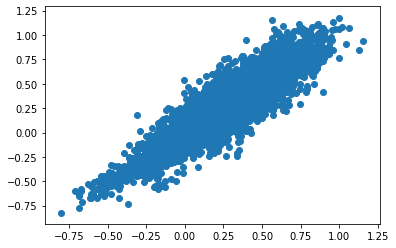

In [51]:
plt.scatter(model_3.fittedvalues, y)
plt.show()

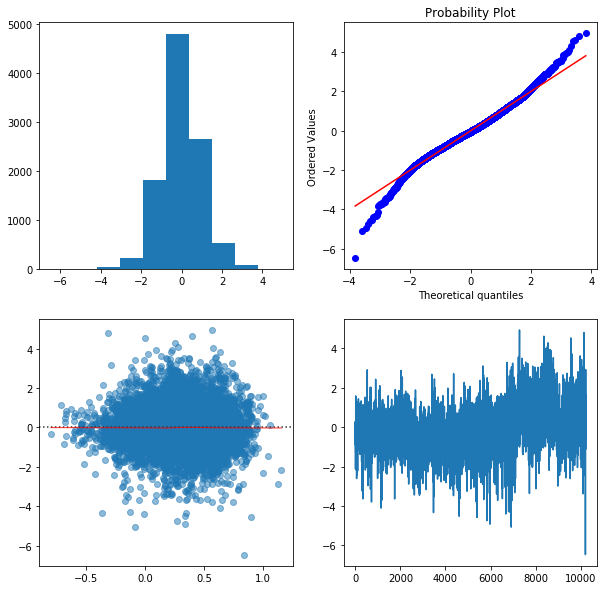

In [52]:
Model_Diagnostic(data = X, model = model_3, date = train['Date'])
# A little bit heavy-tailed
# Increasing variance
# Increasing trend with time less significant

In [53]:
SSE = np.sum((np.exp(y) - np.exp(model_3.fittedvalues))**2)
SST = np.sum((np.exp(y) - np.mean(np.exp(y)))**2)
1-(SSE/(X.shape[0] - X.shape[1] - 1))/(SST/(X.shape[0] - 1))
# Improve a lot.

0.788236773236342

## Model 4

We tried to use total volume of avocadoes with different size and total amount of bags with different size to see if useful information can be extracted.

In [54]:
X = train[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]
y = train['AveragePrice']

In [55]:
print((train['4046']+train['4225']+train['4770']==train['Total Volume']).sum()/len(train))
print((train['Small Bags']+train['Large Bags']+train['XLarge Bags']==train['Total Bags']).sum()/len(train))

0.0005871415989822879
0.7762990507877483


In [56]:
print((train['4046'] <= 0).sum())
print((train['4225'] <= 0).sum())
print((train['4770'] <= 0).sum())

126
34
3028


In [57]:
print((train['Small Bags'] <= 0).sum())
print((train['Large Bags'] <= 0).sum())
print((train['XLarge Bags'] <= 0).sum())

85
1323
6717


In [58]:
X = X.rename(columns = {'Small Bags': 'Small_Bags',
                        'Large Bags': 'Large_Bags',
                        'XLarge Bags': 'XLarge_Bags'})
X.head()

4046       4225     4770  Small_Bags  Large_Bags  XLarge_Bags  \
47  7059.86      63.08     0.00     3528.04        6.67         0.00   
6    535.84    3567.35     0.00     5192.81     1458.39         0.00   
46  3907.11  131463.63  1679.79    30174.49   153260.18         7.48   
39   758.52    4642.83     0.00        0.00      210.41         0.00   
27  5987.76  434222.79  3399.30    94362.33     5241.02      2675.83   

            type            region       Date  
47       organic           Houston 2016-01-31  
6        organic  CincinnatiDayton 2018-02-11  
46  conventional  CincinnatiDayton 2017-02-12  
39       organic           Spokane 2015-03-29  
27  conventional            Boston 2017-06-25

In [59]:
y = np.log(y)
y = y.rename('log_AveragePrice', axis = 1)

In [60]:
df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

In [61]:
df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

In [62]:
X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
               'Summer' if (x == 6 or x == 7 or x == 8) else
               'Autumn' if (x == 9 or x == 10 or x == 11) else
               'Winter' for x in pd.DatetimeIndex(X['Date']).month]
X = X.drop('Date', axis = 1)

In [63]:
df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
X = pd.concat([X, df], axis = 1).drop('season', axis = 1)

In [64]:
X['4046_organic'] = X['4046'] * X['organic']
X['4225_organic'] = X['4225'] * X['organic']
X['4770_organic'] = X['4770'] * X['organic']

X['Small_Bags_organic'] = X['Small_Bags'] * X['organic']
X['Large_Bags_organic'] = X['Large_Bags'] * X['organic']
X['XLarge_Bags_organic'] = X['XLarge_Bags'] * X['organic']

In [65]:
for season in ['Spring', 'Summer', 'Autumn']:
    col_name = '4046' + '_' + season
    X[col_name] = X['4046'] * X[season]
    col_name = '4225' + '_' + season
    X[col_name] = X['4225'] * X[season]
    col_name = '4770' + '_' + season
    X[col_name] = X['4770'] * X[season]
    
    col_name = 'Small_Bags' + '_' + season
    X[col_name] = X['Small_Bags'] * X[season]
    col_name = 'Large_Bags' + '_' + season
    X[col_name] = X['Large_Bags'] * X[season]
    col_name = 'XLarge_Bags' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X[season]
    
    col_name = 'organic' + '_' + season
    X[col_name] = X['organic'] * X[season]
    
    col_name = '4046' + '_' + 'organic' + '_' + season
    X[col_name] = X['4046'] * X['organic'] * X[season]
    col_name = '4225' + '_' + 'organic' + '_' + season
    X[col_name] = X['4225'] * X['organic'] * X[season]
    col_name = '4770' + '_' + 'organic' + '_' + season
    X[col_name] = X['4770'] * X['organic'] * X[season]    
    
    col_name = 'Small_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Small_Bags'] * X['organic'] * X[season]
    col_name = 'Large_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Large_Bags'] * X['organic'] * X[season]
    col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X['organic'] * X[season]    

In [66]:
for region in train['region'].unique():
    if region != 'HarrisburgScranton':
        col_name = '4046' + '_' + region
        X[col_name] = X['4046'] * X[region]
        col_name = '4225' + '_' + region
        X[col_name] = X['4225'] * X[region]
        col_name = '4770' + '_' + region
        X[col_name] = X['4770'] * X[region]
        
        col_name = 'Small_Bags' + '_' + region
        X[col_name] = X['Small_Bags'] * X[region]
        col_name = 'Large_Bags' + '_' + region
        X[col_name] = X['Large_Bags'] * X[region]
        col_name = 'XLarge_Bags' + '_' + region        
        X[col_name] = X['XLarge_Bags'] * X[region]
        
        col_name = 'organic' + '_' + region
        X[col_name] = X['organic'] * X[region]
        
        col_name = '4046' + '_' + 'organic' + '_' + region
        X[col_name] = X['4046'] * X['organic'] * X[region]
        col_name = '4225' + '_' + 'organic' + '_' + region
        X[col_name] = X['4225'] * X['organic'] * X[region]
        col_name = '4770' + '_' + 'organic' + '_' + region
        X[col_name] = X['4770'] * X['organic'] * X[region]
        
        col_name = 'Small_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Small_Bags'] * X['organic'] * X[region]
        col_name = 'Large_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Large_Bags'] * X['organic'] * X[region]        
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region]        
        
        for season in ['Spring', 'Summer', 'Autumn']:
            col_name = region + '_' + season
            X[col_name] = X[region] * X[season]
            
            col_name = '4046' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X[region] * X[season]
            col_name = '4225' + '_' + region + '_' + season
            X[col_name] = X['4225'] * X[region] * X[season]            
            col_name = '4770' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X[region] * X[season]
            
            col_name = 'Small_Bags' + '_' + region + '_' + season
            X[col_name] = X['Small_Bags'] * X[region] * X[season]
            col_name = 'Large_Bags' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X[region] * X[season]            
            col_name = 'XLarge_Bags' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X[region] * X[season]            
            
            col_name = 'organic' + '_' + region + '_' + season
            X[col_name] = X['organic'] * X[region] * X[season]
            
            col_name = '4046' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X['organic'] * X[region] * X[season]
            col_name = '4225' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4225'] * X['organic'] * X[region] * X[season]            
            col_name = '4770' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X['organic'] * X[region] * X[season]            
            
            col_name = 'Small_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Small_Bags'] * X['organic'] * X[region] * X[season]
            col_name = 'Large_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X['organic'] * X[region] * X[season]            
            col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] * X[season]            

In [67]:
X.head()

4046       4225     4770  Small_Bags  Large_Bags  XLarge_Bags  organic  \
47  7059.86      63.08     0.00     3528.04        6.67         0.00        1   
6    535.84    3567.35     0.00     5192.81     1458.39         0.00        1   
46  3907.11  131463.63  1679.79    30174.49   153260.18         7.48        0   
39   758.52    4642.83     0.00        0.00      210.41         0.00        1   
27  5987.76  434222.79  3399.30    94362.33     5241.02      2675.83        0   

    Albany  Atlanta  BaltimoreWashington  ...  Small_Bags_Indianapolis_Autumn  \
47       0        0                    0  ...                             0.0   
6        0        0                    0  ...                             0.0   
46       0        0                    0  ...                             0.0   
39       0        0                    0  ...                             0.0   
27       0        0                    0  ...                             0.0   

    Large_Bags_Indianapolis_Autumn  XLarge_Bags_Indianapolis_Autumn  \
47                             0.0                              0.0   
6                              0.0                              0.0   
46                             0.0                              0.0   
39                             0.0                              0.0   
27                             0.0                              0.0   

    organic_Indianapolis_Autumn  4046_organic_Indianapolis_Autumn  \
47                            0                               0.0   
6                             0                               0.0   
46                            0                               0.0   
39                            0                               0.0   
27                            0                               0.0   

    4225_organic_Indianapolis_Autumn  4770_organic_Indianapolis_Autumn  \
47                               0.0                               0.0   
6                                0.0                               0.0   
46                               0.0                               0.0   
39                               0.0                               0.0   
27                               0.0                               0.0   

    Small_Bags_organic_Indianapolis_Autumn  \
47                                     0.0   
6                                      0.0   
46                                     0.0   
39                                     0.0   
27                                     0.0   

    Large_Bags_organic_Indianapolis_Autumn  \
47                                     0.0   
6                                      0.0   
46                                     0.0   
39                                     0.0   
27                                     0.0   

    XLarge_Bags_organic_Indianapolis_Autumn  
47                                      0.0  
6                                       0.0  
46                                      0.0  
39                                      0.0  
27                                      0.0  

[5 rows x 3023 columns]

In [68]:
model_4 = sm.OLS(y, sm.add_constant(X)).fit()
model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_AveragePrice   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     29.56
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:06:28   Log-Likelihood:                 10857.
No. Observations:               10219   AIC:                        -1.621e+04
Df Residuals:                    7468   BIC:                             3683.
Df Model:                        2750                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.3410      0.145      2.345      0.019       0.056       0.626
4046                                           -2.442e-07   1.09e-06     -0.224      0.823   -2.38e-06    1.89e-06
4225                                           -1.048e-06   6.42e-07     -1.633      0.102   -2.31e-06     2.1e-07
4770                                            4.195e-05    2.8e-05      1.496      0.135    -1.3e-05    9.69e-05
Small_Bags                                     -9.626e-07      2e-06     -0.481      0.631   -4.89e-06    2.96e-06
Large_Bags                                          1e-05   7.12e-06      1.405      0.160   -3.95e-06     2.4e-05
XLarge_Bags                                     4.158e-05   6.47e-05      0.643      0.520   -8.53e-05       0.000
organic                                            0.2707      0.156      1.732      0.083      -0.036       0.577
Albany                                             0.0901      0.171      0.527      0.598      -0.245       0.425
Atlanta                                           -0.1532      0.175     -0.876      0.381      -0.496       0.190
BaltimoreWashington                                0.1463      0.178      0.823      0.411      -0.202       0.495
Boise                                             -0.0740      0.195     -0.379      0.705      -0.457       0.309
Boston                                            -0.0667      0.189     -0.353      0.724      -0.437       0.304
BuffaloRochester                                   0.1493      0.184      0.811      0.417      -0.212       0.510
California                                        -0.0715      0.181     -0.395      0.693      -0.426       0.283
Charlotte                                          0.0434      0.165      0.263      0.792      -0.280       0.366
Chicago                                            0.3973      0.189      2.104      0.035       0.027       0.767
CincinnatiDayton                                  -0.0198      0.174     -0.114      0.909      -0.361       0.321
Columbus                                          -0.0406      0.163     -0.249      0.803      -0.360       0.279
DallasFtWorth                                     -0.0516      0.209     -0.247      0.805      -0.462       0.359
Denver                                            -0.0731      0.215     -0.340      0.734      -0.494       0.348
Detroit                                            0.1088      0.185      0.587      0.557      -0.255       0.472
GrandRapids                                       -0.0241      0.186     -0.130      0.897      -0.389       0.340
GreatLakes                                        -0.1184      0.186     -0.637      0.524   

In [69]:
X.T[X.sum() == 0].index

Index(['XLarge_Bags_organic_Houston', '4770_organic_Houston_Spring',
       'XLarge_Bags_organic_Houston_Spring', '4770_organic_Houston_Summer',
       'XLarge_Bags_organic_Houston_Summer', '4770_organic_Houston_Autumn',
       'XLarge_Bags_organic_Houston_Autumn', '4770_organic_CincinnatiDayton',
       'XLarge_Bags_organic_CincinnatiDayton',
       '4770_organic_CincinnatiDayton_Spring',
       ...
       'XLarge_Bags_organic_Midsouth', 'XLarge_Bags_organic_Midsouth_Spring',
       'XLarge_Bags_organic_Midsouth_Summer',
       'XLarge_Bags_organic_Midsouth_Autumn',
       'XLarge_Bags_organic_Indianapolis',
       'XLarge_Bags_organic_Indianapolis_Spring',
       '4770_organic_Indianapolis_Summer',
       'XLarge_Bags_organic_Indianapolis_Summer',
       '4770_organic_Indianapolis_Autumn',
       'XLarge_Bags_organic_Indianapolis_Autumn'],
      dtype='object', length=263)

In [70]:
X['XLarge_Bags'].sum(), X['organic'].sum(), X['Houston'].sum()

(31212559.62, 5028, 194)

In [71]:
(X['XLarge_Bags'] * X['organic']).sum(), (X['XLarge_Bags'] * X['Houston']).sum(), (X['Houston'] * X['organic']).sum()

(6983.66, 220698.25999999998, 97)

In [72]:
(X['XLarge_Bags'] * X['organic'] * X['Houston']).sum()
# It may be because in Houston, the amount of organic avocadoes bought by customers is not too large 
# that bags with XLarge size are needed.
# Other are similar cases

0.0

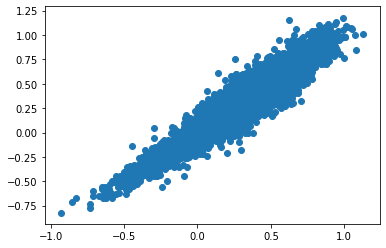

In [73]:
plt.scatter(model_4.fittedvalues, y)
plt.show()

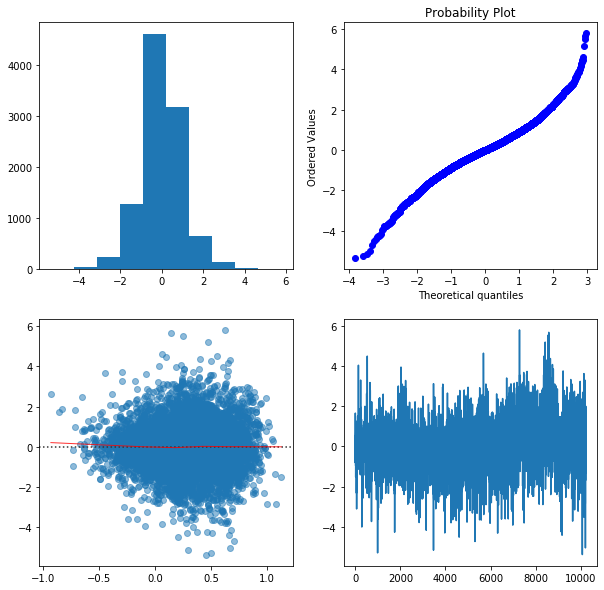

In [74]:
Model_Diagnostic(data = X, model = model_4, date = train['Date'])
# Right-skewed
# Increasing variance
# Constant trend along time

In [75]:
SSE = np.sum((np.exp(y) - np.exp(model_4.fittedvalues))**2)
SST = np.sum((np.exp(y) - np.mean(np.exp(y)))**2)
1-(SSE/(X.shape[0] - X.shape[1] - 1))/(SST/(X.shape[0] - 1))
# Improve

0.8563429423711412

# Model 5

In [76]:
X = train[['4046', '4225', '4770']]

vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X).values, i) for i in range(X.shape[1] + 1)]
vif['feature'] = sm.add_constant(X).columns
vif.drop(0).sort_values('vif', ascending = False)
# They are highly correlated.

vif feature
2  11.290474    4225
1   7.552945    4046
3   5.602241    4770

In [77]:
X = train[['4046', '4770']]

vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X).values, i) for i in range(X.shape[1] + 1)]
vif['feature'] = sm.add_constant(X).columns
vif.drop(0).sort_values('vif', ascending = False)

vif feature
1  3.725077    4046
2  3.725077    4770

In [78]:
X = train[['4046', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags']]

vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X).values, i) for i in range(X.shape[1] + 1)]
vif['feature'] = sm.add_constant(X).columns
vif.drop(0).sort_values('vif', ascending = False)

vif      feature
3  15.506387   Small Bags
1   8.951910         4046
4   5.347125   Large Bags
2   3.990967         4770
5   3.106099  XLarge Bags

In [79]:
X = train[['4046', '4770', 'Large Bags', 'XLarge Bags']]

vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X).values, i) for i in range(X.shape[1] + 1)]
vif['feature'] = sm.add_constant(X).columns
vif.drop(0).sort_values('vif', ascending = False)

vif      feature
1  5.647309         4046
2  3.979037         4770
3  3.605069   Large Bags
4  2.254993  XLarge Bags

In [80]:
X = train[['4046', '4770', 'Large Bags', 'XLarge Bags', 'type']]

df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X).values, i) for i in range(X.shape[1] + 1)]
vif['feature'] = sm.add_constant(X).columns
vif.drop(0).sort_values('vif', ascending = False)

vif      feature
1  5.664467         4046
2  3.982899         4770
3  3.605726   Large Bags
4  2.255774  XLarge Bags
5  1.052404      organic

In [81]:
X = train[['4046', '4770', 'Large Bags', 'XLarge Bags', 'type', 'region']]

df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X).values, i) for i in range(X.shape[1] + 1)]
vif['feature'] = sm.add_constant(X).columns
vif.drop(0).sort_values('vif', ascending = False)

vif              feature
1   7.164942                 4046
2   4.710435                 4770
3   4.414400           Large Bags
56  2.973230              TotalUS
4   2.433142          XLarge Bags
57  2.068414                 West
21  2.055232           GreatLakes
38  2.030572        PhoenixTucson
49  2.015796        SouthCarolina
45  2.006029           Sacramento
10  2.001184               Boston
30  1.978075             Midsouth
34  1.977418            Northeast
42  1.977399    RaleighGreensboro
27  1.975587           LosAngeles
15  1.974604     CincinnatiDayton
7   1.973032              Atlanta
41  1.972762             Portland
47  1.972617         SanFrancisco
8   1.972615  BaltimoreWashington
22  1.971829  HartfordSpringfield
17  1.970197        DallasFtWorth
19  1.967781              Detroit
43  1.966948      RichmondNorfolk
23  1.964645              Houston
55  1.962705                Tampa
37  1.962177         Philadelphia
11  1.957306     BuffaloRochester
51  1.954913            Southeast
20  1.954092          GrandRapids
25  1.952540         Jacksonville
53  1.952439              StLouis
32  1.947779     NewOrleansMobile
9   1.947563                Boise
6   1.947562               Albany
52  1.947545              Spokane
54  1.947487             Syracuse
39  1.942635           Pittsburgh
58  1.940033     WestTexNewMexico
50  1.936497         SouthCentral
13  1.933877            Charlotte
31  1.932931            Nashville
29  1.929662    MiamiFtLauderdale
14  1.928231              Chicago
46  1.918561             SanDiego
16  1.908708             Columbus
48  1.904215              Seattle
35  1.903906   NorthernNewEngland
40  1.903845               Plains
12  1.900610           California
26  1.899658             LasVegas
24  1.894339         Indianapolis
33  1.880376              NewYork
18  1.875864               Denver
36  1.874937              Orlando
44  1.849974              Roanoke
28  1.845334           Louisville
5   1.108681              organic

In [82]:
X = train[['4046', '4770', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]

df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
               'Summer' if (x == 6 or x == 7 or x == 8) else
               'Autumn' if (x == 9 or x == 10 or x == 11) else
               'Winter' for x in pd.DatetimeIndex(X['Date']).month]
X = X.drop('Date', axis = 1)

df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
X = pd.concat([X, df], axis = 1).drop('season', axis = 1)

vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X).values, i) for i in range(X.shape[1] + 1)]
vif['feature'] = sm.add_constant(X).columns
vif.drop(0).sort_values('vif', ascending = False)

vif      feature
1   7.169765         4046
2   4.712416         4770
3   4.440470   Large Bags
56  2.974465      TotalUS
4   2.459493  XLarge Bags
..       ...          ...
28  1.845551   Louisville
60  1.427212       Spring
61  1.414886       Summer
59  1.404553       Autumn
5   1.108976      organic

[61 rows x 2 columns]

In [83]:
X = train[['4046', '4770', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]
y = train['AveragePrice']

y = np.log(y)
y = y.rename('log_AveragePrice', axis = 1)

X = X.rename(columns = {'Large Bags': 'Large_Bags',
                        'XLarge Bags': 'XLarge_Bags'})

df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
               'Summer' if (x == 6 or x == 7 or x == 8) else
               'Autumn' if (x == 9 or x == 10 or x == 11) else
               'Winter' for x in pd.DatetimeIndex(X['Date']).month]
X = X.drop('Date', axis = 1)

df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
X = pd.concat([X, df], axis = 1).drop('season', axis = 1)

X['4046_organic'] = X['4046'] * X['organic']
X['4770_organic'] = X['4770'] * X['organic']

X['Large_Bags_organic'] = X['Large_Bags'] * X['organic']
X['XLarge_Bags_organic'] = X['XLarge_Bags'] * X['organic']

for season in ['Spring', 'Summer', 'Autumn']:
    col_name = '4046' + '_' + season
    X[col_name] = X['4046'] * X[season]       
    col_name = '4770' + '_' + season
    X[col_name] = X['4770'] * X[season]

    col_name = 'Large_Bags' + '_' + season
    X[col_name] = X['Large_Bags'] * X[season]
    col_name = 'XLarge_Bags' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X[season]

    col_name = 'organic' + '_' + season
    X[col_name] = X['organic'] * X[season]

    col_name = '4046' + '_' + 'organic' + '_' + season
    X[col_name] = X['4046'] * X['organic'] * X[season]
    col_name = '4770' + '_' + 'organic' + '_' + season
    X[col_name] = X['4770'] * X['organic'] * X[season] 

    col_name = 'Large_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Large_Bags'] * X['organic'] * X[season]
    col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X['organic'] * X[season]         

for region in train['region'].unique():
    if region != 'HarrisburgScranton': 
        col_name = '4046' + '_' + region
        X[col_name] = X['4046'] * X[region]     
        col_name = '4770' + '_' + region
        X[col_name] = X['4770'] * X[region]

        col_name = 'Large_Bags' + '_' + region
        X[col_name] = X['Large_Bags'] * X[region]
        col_name = 'XLarge_Bags' + '_' + region        
        X[col_name] = X['XLarge_Bags'] * X[region]

        col_name = 'organic' + '_' + region
        X[col_name] = X['organic'] * X[region]

        col_name = '4046' + '_' + 'organic' + '_' + region
        X[col_name] = X['4046'] * X['organic'] * X[region]
        col_name = '4770' + '_' + 'organic' + '_' + region
        X[col_name] = X['4770'] * X['organic'] * X[region]

        col_name = 'Large_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Large_Bags'] * X['organic'] * X[region] 
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] 

        for season in ['Spring', 'Summer', 'Autumn']:
            col_name = region + '_' + season
            X[col_name] = X[region] * X[season]

            col_name = '4046' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X[region] * X[season]
            col_name = '4770' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X[region] * X[season]

            col_name = 'Large_Bags' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X[region] * X[season]
            col_name = 'XLarge_Bags' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X[region] * X[season]

            col_name = 'organic' + '_' + region + '_' + season
            X[col_name] = X['organic'] * X[region] * X[season]
            col_name = '4046' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X['organic'] * X[region] * X[season]
            col_name = '4770' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X['organic'] * X[region] * X[season]  

            col_name = 'Large_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X['organic'] * X[region] * X[season]
            col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] * X[season]

In [84]:
model_5 = sm.OLS(y, sm.add_constant(X)).fit()
model_5.summary()
# Not much change in standard error

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_AveragePrice   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     25.96
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:10:04   Log-Likelihood:                 8061.4
No. Observations:               10219   AIC:                        -1.235e+04
Df Residuals:                    8332   BIC:                             1298.
Df Model:                        1886                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.1511      0.062      2.434      0.015       0.029       0.273
4046                                           -7.161e-07   1.29e-06     -0.553      0.580   -3.25e-06    1.82e-06
4770                                            3.975e-05   3.45e-05      1.153      0.249   -2.78e-05       0.000
Large_Bags                                      1.368e-05    7.4e-06      1.848      0.065   -8.28e-07    2.82e-05
XLarge_Bags                                     2.617e-05    7.9e-05      0.331      0.740      -0.000       0.000
organic                                            0.3631      0.082      4.411      0.000       0.202       0.524
Albany                                             0.0280      0.079      0.355      0.723      -0.127       0.182
Atlanta                                            0.0376      0.135      0.279      0.780      -0.227       0.302
BaltimoreWashington                                0.2039      0.093      2.203      0.028       0.022       0.385
Boise                                             -0.1488      0.160     -0.933      0.351      -0.462       0.164
Boston                                             0.0160      0.074      0.217      0.828      -0.129       0.161
BuffaloRochester                                   0.2558      0.101      2.528      0.011       0.057       0.454
California                                         0.1822      0.146      1.252      0.211      -0.103       0.468
Charlotte                                          0.1465      0.108      1.359      0.174      -0.065       0.358
Chicago                                            0.2658      0.138      1.932      0.053      -0.004       0.536
CincinnatiDayton                                  -0.0878      0.090     -0.976      0.329      -0.264       0.089
Columbus                                           0.1292      0.107      1.210      0.226      -0.080       0.338
DallasFtWorth                                     -0.0829      0.135     -0.614      0.539      -0.348       0.182
Denver                                            -0.2069      0.168     -1.233      0.218      -0.536       0.122
Detroit                                            0.1667      0.114      1.460      0.144      -0.057       0.391
GrandRapids                                       -0.0242      0.087     -0.280      0.780      -0.194       0.145
GreatLakes                                         0.1215      0.131      0.931      0.352      -0.134       0.377
HartfordSpringfield                                0.1031      0.070      1.475      0.140      -0.034       0.240
Houston                                           -0.0589      0.113     -0.522      0.601   

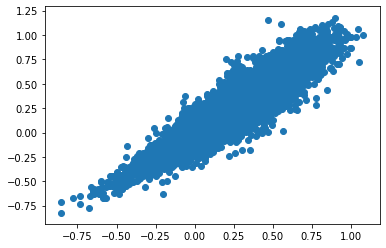

In [85]:
plt.scatter(model_5.fittedvalues, y)
plt.show()

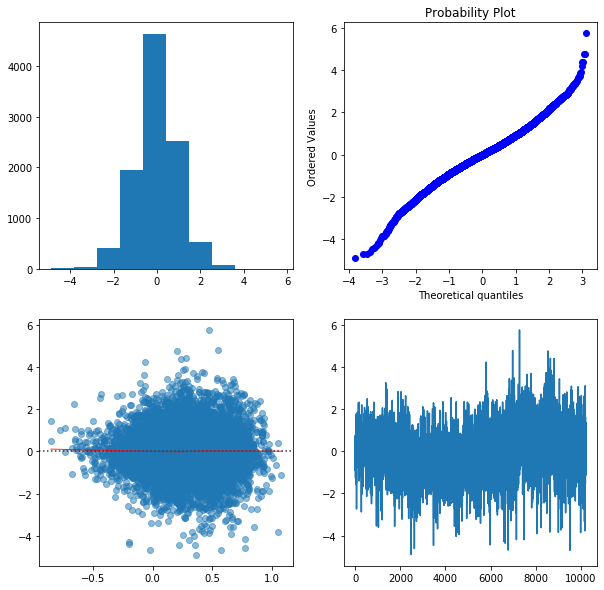

In [86]:
Model_Diagnostic(data = X, model = model_5, date = train['Date'])

In [87]:
SSE = np.sum((np.exp(y) - np.exp(model_5.fittedvalues))**2)
SST = np.sum((np.exp(y) - np.mean(np.exp(y)))**2)
1-(SSE/(X.shape[0] - X.shape[1] - 1))/(SST/(X.shape[0] - 1))
# Drop a lot.

0.7843363153633598

## Model 6

We can see that the variance is not equal. Therefore, we tried the weighted least squares to fix this problem.

In [88]:
X = train[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]
y = train['AveragePrice']

y = np.log(y)
y = y.rename('log_AveragePrice', axis = 1)

X = X.rename(columns = {'Small Bags': 'Small_Bags',
                        'Large Bags': 'Large_Bags',
                        'XLarge Bags': 'XLarge_Bags'})

df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
               'Summer' if (x == 6 or x == 7 or x == 8) else
               'Autumn' if (x == 9 or x == 10 or x == 11) else
               'Winter' for x in pd.DatetimeIndex(X['Date']).month]
X = X.drop('Date', axis = 1)

df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
X = pd.concat([X, df], axis = 1).drop('season', axis = 1)

X['4046_organic'] = X['4046'] * X['organic']
X['4225_organic'] = X['4225'] * X['organic']
X['4770_organic'] = X['4770'] * X['organic']

X['Small_Bags_organic'] = X['Small_Bags'] * X['organic']
X['Large_Bags_organic'] = X['Large_Bags'] * X['organic']
X['XLarge_Bags_organic'] = X['XLarge_Bags'] * X['organic']

for season in ['Spring', 'Summer', 'Autumn']:
    col_name = '4046' + '_' + season
    X[col_name] = X['4046'] * X[season]
    col_name = '4225' + '_' + season
    X[col_name] = X['4225'] * X[season]
    col_name = '4770' + '_' + season
    X[col_name] = X['4770'] * X[season]
    
    col_name = 'Small_Bags' + '_' + season
    X[col_name] = X['Small_Bags'] * X[season]
    col_name = 'Large_Bags' + '_' + season
    X[col_name] = X['Large_Bags'] * X[season]
    col_name = 'XLarge_Bags' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X[season]
    
    col_name = 'organic' + '_' + season
    X[col_name] = X['organic'] * X[season]
    
    col_name = '4046' + '_' + 'organic' + '_' + season
    X[col_name] = X['4046'] * X['organic'] * X[season]
    col_name = '4225' + '_' + 'organic' + '_' + season
    X[col_name] = X['4225'] * X['organic'] * X[season]
    col_name = '4770' + '_' + 'organic' + '_' + season
    X[col_name] = X['4770'] * X['organic'] * X[season]    
    
    col_name = 'Small_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Small_Bags'] * X['organic'] * X[season]
    col_name = 'Large_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Large_Bags'] * X['organic'] * X[season]
    col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X['organic'] * X[season]    

for region in train['region'].unique():
    if region != 'HarrisburgScranton':
        col_name = '4046' + '_' + region
        X[col_name] = X['4046'] * X[region]
        col_name = '4225' + '_' + region
        X[col_name] = X['4225'] * X[region]
        col_name = '4770' + '_' + region
        X[col_name] = X['4770'] * X[region]
        
        col_name = 'Small_Bags' + '_' + region
        X[col_name] = X['Small_Bags'] * X[region]
        col_name = 'Large_Bags' + '_' + region
        X[col_name] = X['Large_Bags'] * X[region]
        col_name = 'XLarge_Bags' + '_' + region        
        X[col_name] = X['XLarge_Bags'] * X[region]
        
        col_name = 'organic' + '_' + region
        X[col_name] = X['organic'] * X[region]
        
        col_name = '4046' + '_' + 'organic' + '_' + region
        X[col_name] = X['4046'] * X['organic'] * X[region]
        col_name = '4225' + '_' + 'organic' + '_' + region
        X[col_name] = X['4225'] * X['organic'] * X[region]
        col_name = '4770' + '_' + 'organic' + '_' + region
        X[col_name] = X['4770'] * X['organic'] * X[region]
        
        col_name = 'Small_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Small_Bags'] * X['organic'] * X[region]
        col_name = 'Large_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Large_Bags'] * X['organic'] * X[region]        
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region]        
        
        for season in ['Spring', 'Summer', 'Autumn']:
            col_name = region + '_' + season
            X[col_name] = X[region] * X[season]
            
            col_name = '4046' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X[region] * X[season]
            col_name = '4225' + '_' + region + '_' + season
            X[col_name] = X['4225'] * X[region] * X[season]            
            col_name = '4770' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X[region] * X[season]
            
            col_name = 'Small_Bags' + '_' + region + '_' + season
            X[col_name] = X['Small_Bags'] * X[region] * X[season]
            col_name = 'Large_Bags' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X[region] * X[season]            
            col_name = 'XLarge_Bags' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X[region] * X[season]            
            
            col_name = 'organic' + '_' + region + '_' + season
            X[col_name] = X['organic'] * X[region] * X[season]
            
            col_name = '4046' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X['organic'] * X[region] * X[season]
            col_name = '4225' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4225'] * X['organic'] * X[region] * X[season]            
            col_name = '4770' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X['organic'] * X[region] * X[season]            
            
            col_name = 'Small_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Small_Bags'] * X['organic'] * X[region] * X[season]
            col_name = 'Large_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X['organic'] * X[region] * X[season]            
            col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] * X[season]            

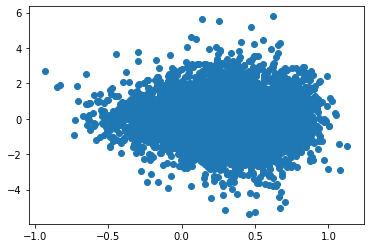

In [89]:
plt.scatter(model_4.fittedvalues, model_4.get_influence().resid_studentized_internal)
plt.show()

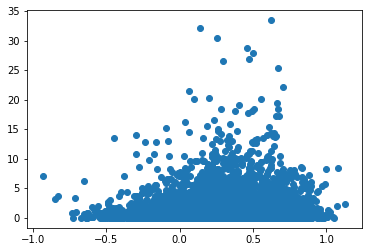

In [90]:
plt.scatter(model_4.fittedvalues, model_4.get_influence().resid_studentized_internal**2)
plt.show()

In [91]:
r = np.abs(model_4.resid)
weight_model = sm.OLS(r, sm.add_constant(model_4.fittedvalues)).fit()
weights = weight_model.fittedvalues
# https://online.stat.psu.edu/stat501/lesson/13/13.1

In [92]:
model_6 = sm.WLS(y, sm.add_constant(X), weights = 1/(weights**2)).fit()
model_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:       log_AveragePrice   R-squared:                       0.922
Model:                            WLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     32.00
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:12:57   Log-Likelihood:                 10930.
No. Observations:               10219   AIC:                        -1.636e+04
Df Residuals:                    7468   BIC:                             3538.
Df Model:                        2750                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.3374      0.140      2.412      0.016       0.063       0.612
4046                                           -2.052e-07   1.05e-06     -0.195      0.846   -2.27e-06    1.86e-06
4225                                           -1.047e-06   6.14e-07     -1.705      0.088   -2.25e-06    1.57e-07
4770                                            4.122e-05   2.78e-05      1.481      0.139   -1.33e-05    9.58e-05
Small_Bags                                     -9.344e-07   1.92e-06     -0.487      0.627    -4.7e-06    2.83e-06
Large_Bags                                      9.987e-06   6.96e-06      1.435      0.151   -3.65e-06    2.36e-05
XLarge_Bags                                     4.215e-05   6.35e-05      0.664      0.507   -8.23e-05       0.000
organic                                            0.2738      0.153      1.795      0.073      -0.025       0.573
Albany                                             0.0929      0.166      0.560      0.575      -0.232       0.418
Atlanta                                           -0.1526      0.165     -0.926      0.354      -0.476       0.170
BaltimoreWashington                                0.1443      0.172      0.840      0.401      -0.192       0.481
Boise                                             -0.0709      0.185     -0.383      0.702      -0.434       0.292
Boston                                            -0.0683      0.181     -0.376      0.707      -0.424       0.287
BuffaloRochester                                   0.1532      0.180      0.851      0.395      -0.200       0.506
California                                        -0.0679      0.169     -0.401      0.688      -0.400       0.264
Charlotte                                          0.0525      0.158      0.333      0.739      -0.257       0.362
Chicago                                            0.3865      0.179      2.158      0.031       0.035       0.738
CincinnatiDayton                                  -0.0315      0.163     -0.193      0.847      -0.350       0.288
Columbus                                          -0.0319      0.155     -0.206      0.837      -0.336       0.272
DallasFtWorth                                     -0.0556      0.189     -0.294      0.769      -0.427       0.316
Denver                                            -0.0806      0.199     -0.405      0.685      -0.470       0.309
Detroit                                            0.1131      0.175      0.647      0.518      -0.230       0.456
GrandRapids                                       -0.0195      0.176     -0.111      0.912      -0.365       0.326
GreatLakes                                        -0.1163      0.176     -0.661      0.509   

In [93]:
model_fitted_y = model_6.fittedvalues
standardized_residuals = OLSInfluence(model_6).resid_studentized_internal

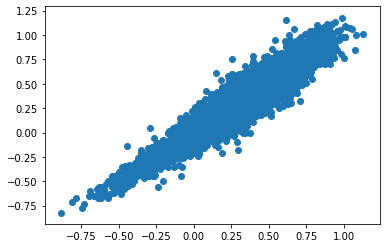

In [94]:
plt.scatter(model_fitted_y, y)
plt.show()

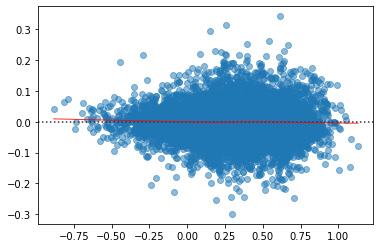

In [95]:
sns.residplot(model_fitted_y, standardized_residuals,
              lowess=True,
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.show()
# Fan shape still exist

# ANOVA

In [96]:
X = train[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]
y = train['AveragePrice']

y = np.log(y)
y = y.rename('log_AveragePrice', axis = 1)

X = X.rename(columns = {'Small Bags': 'Small_Bags',
                        'Large Bags': 'Large_Bags',
                        'XLarge Bags': 'XLarge_Bags'})

df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
regions = df.columns.tolist()
X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
               'Summer' if (x == 6 or x == 7 or x == 8) else
               'Autumn' if (x == 9 or x == 10 or x == 11) else
               'Winter' for x in pd.DatetimeIndex(X['Date']).month]
X = X.drop('Date', axis = 1)

df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
X = pd.concat([X, df], axis = 1).drop('season', axis = 1)

Small_Volume_type = ['4046_organic']
Intermediate_Volume_type = ['4225_organic']
Large_Volume_type = ['4770_organic']

Small_Bags_type = ['Small_Bags_organic']
Large_Bags_type = ['Large_Bags_organic']
XLarge_Bags_type = ['XLarge_Bags_organic']

X['4046_organic'] = X['4046'] * X['organic']
X['4225_organic'] = X['4225'] * X['organic']
X['4770_organic'] = X['4770'] * X['organic']

X['Small_Bags_organic'] = X['Small_Bags'] * X['organic']
X['Large_Bags_organic'] = X['Large_Bags'] * X['organic']
X['XLarge_Bags_organic'] = X['XLarge_Bags'] * X['organic']

Small_Volume_season = []
Intermediate_Volume_season = []
Large_Volume_season = []

Small_Volume_type_season = []
Intermediate_Volume_type_season = []
Large_Volume_type_season = []

Small_Bags_season = []
Large_Bags_season = []
XLarge_Bags_season = []

Small_Bags_type_season = []
Large_Bags_type_season = []
XLarge_Bags_type_season = []

type_season = []

for season in ['Spring', 'Summer', 'Autumn']:
    col_name = '4046' + '_' + season
    X[col_name] = X['4046'] * X[season]
    Small_Volume_season.append(col_name)
    col_name = '4225' + '_' + season
    X[col_name] = X['4225'] * X[season]
    Intermediate_Volume_season.append(col_name)
    col_name = '4770' + '_' + season
    X[col_name] = X['4770'] * X[season]
    Large_Volume_season.append(col_name)

    col_name = 'Small_Bags' + '_' + season
    X[col_name] = X['Small_Bags'] * X[season]
    Small_Bags_season.append(col_name)    
    col_name = 'Large_Bags' + '_' + season
    X[col_name] = X['Large_Bags'] * X[season]
    Large_Bags_season.append(col_name)
    col_name = 'XLarge_Bags' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X[season]
    XLarge_Bags_season.append(col_name)
    
    col_name = 'organic' + '_' + season
    X[col_name] = X['organic'] * X[season]
    type_season.append(col_name)
    
    col_name = '4046' + '_' + 'organic' + '_' + season
    X[col_name] = X['4046'] * X['organic'] * X[season]
    Small_Volume_type_season.append(col_name)
    col_name = '4225' + '_' + 'organic' + '_' + season
    X[col_name] = X['4225'] * X['organic'] * X[season]
    Intermediate_Volume_type_season.append(col_name)
    col_name = '4770' + '_' + 'organic' + '_' + season
    X[col_name] = X['4770'] * X['organic'] * X[season] 
    Large_Volume_type_season.append(col_name)
        
    col_name = 'Small_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Small_Bags'] * X['organic'] * X[season]
    Small_Bags_type_season.append(col_name)
    col_name = 'Large_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Large_Bags'] * X['organic'] * X[season]
    Large_Bags_type_season.append(col_name)
    col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X['organic'] * X[season]  
    XLarge_Bags_type_season.append(col_name)        

Small_Volume_region = []
Intermediate_Volume_region = []
Large_Volume_region = []

Small_Volume_region_season = []
Intermediate_Volume_region_season = []
Large_Volume_region_season = []

Small_Volume_type_region = []
Intermediate_Volume_type_region = []
Large_Volume_type_region = []

Small_Volume_type_region_season = []
Intermediate_Volume_type_region_season = []
Large_Volume_type_region_season = []

Small_Bags_region = []
Large_Bags_region = []
XLarge_Bags_region = []

Small_Bags_region_season = []
Large_Bags_region_season = []
XLarge_Bags_region_season = []

Small_Bags_type_region = []
Large_Bags_type_region = []
XLarge_Bags_type_region = []

Small_Bags_type_region_season = []
Large_Bags_type_region_season = []
XLarge_Bags_type_region_season = []

type_region = []
region_season = []
type_region_season = []

for region in regions:
    col_name = '4046' + '_' + region
    X[col_name] = X['4046'] * X[region]
    Small_Volume_region.append(col_name)    
    col_name = '4225' + '_' + region
    X[col_name] = X['4225'] * X[region]
    Intermediate_Volume_region.append(col_name)    
    col_name = '4770' + '_' + region
    X[col_name] = X['4770'] * X[region]
    Large_Volume_region.append(col_name)
        
    col_name = 'Small_Bags' + '_' + region
    X[col_name] = X['Small_Bags'] * X[region]
    Small_Bags_region.append(col_name)
    col_name = 'Large_Bags' + '_' + region
    X[col_name] = X['Large_Bags'] * X[region]
    Large_Bags_region.append(col_name)
    col_name = 'XLarge_Bags' + '_' + region        
    X[col_name] = X['XLarge_Bags'] * X[region]
    XLarge_Bags_region.append(col_name)
        
    col_name = 'organic' + '_' + region
    X[col_name] = X['organic'] * X[region]
    type_region.append(col_name)
        
    col_name = '4046' + '_' + 'organic' + '_' + region
    X[col_name] = X['4046'] * X['organic'] * X[region]
    Small_Volume_type_region.append(col_name)
    col_name = '4225' + '_' + 'organic' + '_' + region
    X[col_name] = X['4225'] * X['organic'] * X[region]
    Intermediate_Volume_type_region.append(col_name)
    col_name = '4770' + '_' + 'organic' + '_' + region
    X[col_name] = X['4770'] * X['organic'] * X[region]
    Large_Volume_type_region.append(col_name)
        
    col_name = 'Small_Bags' + '_' + 'organic' + '_' + region
    X[col_name] = X['Small_Bags'] * X['organic'] * X[region]
    Small_Bags_type_region.append(col_name)
    col_name = 'Large_Bags' + '_' + 'organic' + '_' + region
    X[col_name] = X['Large_Bags'] * X['organic'] * X[region] 
    Large_Bags_type_region.append(col_name)
    col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region
    X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] 
    XLarge_Bags_type_region.append(col_name)
    
    for season in ['Spring', 'Summer', 'Autumn']:
        col_name = region + '_' + season
        X[col_name] = X[region] * X[season]
        region_season.append(col_name)
        
        col_name = '4046' + '_' + region + '_' + season
        X[col_name] = X['4046'] * X[region] * X[season]
        Small_Volume_region_season.append(col_name)
        col_name = '4225' + '_' + region + '_' + season
        X[col_name] = X['4225'] * X[region] * X[season] 
        Intermediate_Volume_region_season.append(col_name)
        col_name = '4770' + '_' + region + '_' + season
        X[col_name] = X['4770'] * X[region] * X[season]
        Large_Volume_region_season.append(col_name)
        
        col_name = 'Small_Bags' + '_' + region + '_' + season
        X[col_name] = X['Small_Bags'] * X[region] * X[season]
        Small_Bags_region_season.append(col_name)
        col_name = 'Large_Bags' + '_' + region + '_' + season
        X[col_name] = X['Large_Bags'] * X[region] * X[season]
        Large_Bags_region_season.append(col_name)
        col_name = 'XLarge_Bags' + '_' + region + '_' + season
        X[col_name] = X['XLarge_Bags'] * X[region] * X[season]
        XLarge_Bags_region_season.append(col_name)
        
        col_name = 'organic' + '_' + region + '_' + season
        X[col_name] = X['organic'] * X[region] * X[season]
        type_region_season.append(col_name)
        
        col_name = '4046' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['4046'] * X['organic'] * X[region] * X[season]
        Small_Volume_type_region_season.append(col_name)
        col_name = '4225' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['4225'] * X['organic'] * X[region] * X[season] 
        Intermediate_Volume_type_region_season.append(col_name)
        col_name = '4770' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['4770'] * X['organic'] * X[region] * X[season]  
        Large_Volume_type_region_season.append(col_name)
        
        col_name = 'Small_Bags' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['Small_Bags'] * X['organic'] * X[region] * X[season]
        Small_Bags_type_region_season.append(col_name)
        col_name = 'Large_Bags' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['Large_Bags'] * X['organic'] * X[region] * X[season]
        Large_Bags_type_region_season.append(col_name)
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] * X[season]  
        XLarge_Bags_type_region_season.append(col_name)

In [97]:
full_model = sm.OLS(y, sm.add_constant(X)).fit()

## Linear Combination of 4 Way Interaction

In [98]:
reduced_4_way = Small_Volume_type_region_season + Intermediate_Volume_type_region_season + Large_Volume_type_region_season + \
                Small_Bags_type_region_season + Large_Bags_type_region_season + XLarge_Bags_type_region_season

In [99]:
reduced_4_way_model = sm.OLS(y, sm.add_constant(X.drop(reduced_4_way, axis = 1))).fit()

In [100]:
full_SSE = full_model.ssr
reduced_SSE = reduced_4_way_model.ssr

delta_df = full_model.df_model - reduced_4_way_model.df_model
df_denom = (full_model.fittedvalues.shape[0] - full_model.df_model)

f_stat = (reduced_SSE - full_SSE) / (delta_df * full_model.scale)
p_value = stats.f.sf(f_stat, delta_df, df_denom)

In [101]:
print('F statistic:', f_stat)
print('p-value:', p_value)
# Significant

F statistic: 2.896113683865036
p-value: 5.25869066669213e-113


## Small Volume * type * region * season

In [102]:
Small_Volume_type_region_season_model = sm.OLS(y, sm.add_constant(X.drop(Small_Volume_type_region_season, axis = 1))).fit()

In [103]:
full_SSE = full_model.ssr
reduced_SSE = Small_Volume_type_region_season_model.ssr

delta_df = full_model.df_model - Small_Volume_type_region_season_model.df_model
df_denom = (full_model.fittedvalues.shape[0] - full_model.df_model)

f_stat = (reduced_SSE - full_SSE) / (delta_df * full_model.scale)
p_value = stats.f.sf(f_stat, delta_df, df_denom)

In [104]:
print('F statistic:', f_stat)
print('p-value:', p_value)
# Significant

F statistic: 3.0207559777607886
p-value: 1.557112942262578e-32


## Intermediate Volume * type * region * season

In [105]:
Intermediate_Volume_type_region_season_model = sm.OLS(y, sm.add_constant(X.drop(Intermediate_Volume_type_region_season, axis = 1))).fit()

In [106]:
full_SSE = full_model.ssr
reduced_SSE = Intermediate_Volume_type_region_season_model.ssr

delta_df = full_model.df_model - Intermediate_Volume_type_region_season_model.df_model
df_denom = (full_model.fittedvalues.shape[0] - full_model.df_model)

f_stat = (reduced_SSE - full_SSE) / (delta_df * full_model.scale)
p_value = stats.f.sf(f_stat, delta_df, df_denom)

In [107]:
print('F statistic:', f_stat)
print('p-value:', p_value)
# Significant

F statistic: 2.573817717291131
p-value: 4.3769389108723724e-23


## Large Volume * type * region * season

In [108]:
Large_Volume_type_region_season_model = sm.OLS(y, sm.add_constant(X.drop(Large_Volume_type_region_season, axis = 1))).fit()

In [109]:
full_SSE = full_model.ssr
reduced_SSE = Large_Volume_type_region_season_model.ssr

delta_df = full_model.df_model - Large_Volume_type_region_season_model.df_model
df_denom = (full_model.fittedvalues.shape[0] - full_model.df_model)

f_stat = (reduced_SSE - full_SSE) / (delta_df * full_model.scale)
p_value = stats.f.sf(f_stat, delta_df, df_denom)

In [110]:
print('F statistic:', f_stat)
print('p-value:', p_value)
# Significant

F statistic: 1.3121263960469305
p-value: 0.024844711624247645


## Small Bags * type * region * season

In [111]:
Small_Bags_type_region_season_model = sm.OLS(y, sm.add_constant(X.drop(Small_Bags_type_region_season, axis = 1))).fit()

In [112]:
full_SSE = full_model.ssr
reduced_SSE = Small_Bags_type_region_season_model.ssr

delta_df = full_model.df_model - Small_Bags_type_region_season_model.df_model
df_denom = (full_model.fittedvalues.shape[0] - full_model.df_model)

f_stat = (reduced_SSE - full_SSE) / (delta_df * full_model.scale)
p_value = stats.f.sf(f_stat, delta_df, df_denom)

In [113]:
print('F statistic:', f_stat)
print('p-value:', p_value)
# Siginificant

F statistic: 3.130248668116472
p-value: 5.974785333638978e-35


## Large Bags * type * region * season

In [114]:
Large_Bags_type_region_season_model = sm.OLS(y, sm.add_constant(X.drop(Large_Bags_type_region_season, axis = 1))).fit()

In [115]:
full_SSE = full_model.ssr
reduced_SSE = Large_Bags_type_region_season_model.ssr

delta_df = full_model.df_model - Large_Bags_type_region_season_model.df_model
df_denom = (full_model.fittedvalues.shape[0] - full_model.df_model)

f_stat = (reduced_SSE - full_SSE) / (delta_df * full_model.scale)
p_value = stats.f.sf(f_stat, delta_df, df_denom)

In [116]:
print('F statistic:', f_stat)
print('p-value:', p_value)
# Siginificant

F statistic: 2.2842991276246956
p-value: 2.5438922325568916e-17


## XLarge Bags * type * region * season

In [117]:
XLarge_Bags_type_region_season_model = sm.OLS(y, sm.add_constant(X.drop(XLarge_Bags_type_region_season, axis = 1))).fit()

In [118]:
full_SSE = full_model.ssr
reduced_SSE = XLarge_Bags_type_region_season_model.ssr

delta_df = full_model.df_model - XLarge_Bags_type_region_season_model.df_model
df_denom = (full_model.fittedvalues.shape[0] - full_model.df_model)

f_stat = (reduced_SSE - full_SSE) / (delta_df * full_model.scale)
p_value = stats.f.sf(f_stat, delta_df, df_denom)

In [119]:
print('F statistic:', f_stat)
print('p-value:', p_value)
# Not siginificant

F statistic: 1.4221854851657176
p-value: 0.14015876520482448


In [120]:
full_model = XLarge_Bags_type_region_season_model

## XLarge Bags * type * region 

In [121]:
XLarge_Bags_type_region_model = sm.OLS(y, sm.add_constant(X.drop(XLarge_Bags_type_region+XLarge_Bags_type_region_season, axis = 1))).fit()

In [122]:
full_SSE = full_model.ssr
reduced_SSE = XLarge_Bags_type_region_model.ssr

delta_df = full_model.df_model - XLarge_Bags_type_region_model.df_model
df_denom = (full_model.fittedvalues.shape[0] - full_model.df_model)

f_stat = (reduced_SSE - full_SSE) / (delta_df * full_model.scale)
p_value = stats.f.sf(f_stat, delta_df, df_denom)

In [123]:
print('F statistic:', f_stat)
print('p-value:', p_value)
# Siginificant

F statistic: 3.431731844651334
p-value: 0.0005993705105886138


## XLarge Bags * type * season

In [124]:
XLarge_Bags_type_season_model = sm.OLS(y, sm.add_constant(X.drop(XLarge_Bags_type_season+XLarge_Bags_type_region_season, axis = 1))).fit()

In [125]:
full_SSE = full_model.ssr
reduced_SSE = XLarge_Bags_type_season_model.ssr

delta_df = full_model.df_model - XLarge_Bags_type_season_model.df_model
df_denom = (full_model.fittedvalues.shape[0] - full_model.df_model)

f_stat = (reduced_SSE - full_SSE) / (delta_df * full_model.scale)
p_value = stats.f.sf(f_stat, delta_df, df_denom)

In [126]:
print('F statistic:', f_stat)
print('p-value:', p_value)
# Not siginificant

F statistic: 1.936746796950655
p-value: 0.12131471176604973


## XLarge Bags * region * season

In [127]:
XLarge_Bags_region_season_model = sm.OLS(y, sm.add_constant(X.drop(XLarge_Bags_region_season+XLarge_Bags_type_region_season, axis = 1))).fit()

In [128]:
full_SSE = full_model.ssr
reduced_SSE = XLarge_Bags_region_season_model.ssr

delta_df = full_model.df_model - XLarge_Bags_region_season_model.df_model
df_denom = (full_model.fittedvalues.shape[0] - full_model.df_model)

f_stat = (reduced_SSE - full_SSE) / (delta_df * full_model.scale)
p_value = stats.f.sf(f_stat, delta_df, df_denom)

In [129]:
print('F statistic:', f_stat)
print('p-value:', p_value)
# Siginificant

F statistic: 1.4499816570817934
p-value: 0.00021679427223714775


## type * region * season

In [130]:
type_region_season_model = sm.OLS(y, sm.add_constant(X.drop(type_region_season+XLarge_Bags_type_region_season, axis = 1))).fit()

In [131]:
full_SSE = full_model.ssr
reduced_SSE = type_region_season_model.ssr

delta_df = full_model.df_model - type_region_season_model.df_model
df_denom = (full_model.fittedvalues.shape[0] - full_model.df_model)

f_stat = (reduced_SSE - full_SSE) / (delta_df * full_model.scale)
p_value = stats.f.sf(f_stat, delta_df, df_denom)

In [132]:
print('F statistic:', f_stat)
print('p-value:', p_value)
# Significant

F statistic: 2.0939757352288146
p-value: 6.108578540800326e-14


In [133]:
full_model = XLarge_Bags_type_season_model

# Model Selection

## Ridge Regression

There may be a serious collinearity problem. We can use ridge regression to reduce its significance.

In [134]:
ridge_cv = RidgeCV(cv = 5, normalize = True).fit(X, y)
ridge_cv.alpha_

1.0

In [135]:
ridge = Ridge(alpha = ridge_cv.alpha_, normalize = True).fit(X, y)

## LASSO Regression

In [136]:
lasso_cv = LassoCV(cv = 5, normalize = True).fit(X, y)
lasso_cv.alpha_

2.159364303372779e-05

In [137]:
lasso = Lasso(alpha = lasso_cv.alpha_, normalize = True).fit(X, y)

In [140]:
print('Number of predictors with non-zero coefficients:', sum(lasso.coef_!=0))
print('Total number of predictors:', len(lasso.coef_))
# Many of the predictors are useless

Number of predictors with non-zero coefficients: 516
Total number of predictors: 3023


In [138]:
lasso_predictors = X.columns[np.where(lasso.coef_!=0)]

lasso_lr = sm.OLS(y, sm.add_constant(X[lasso_predictors])).fit()
lasso_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_AveragePrice   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     96.51
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        10:51:38   Log-Likelihood:                 7476.9
No. Observations:               10219   AIC:                        -1.392e+04
Df Residuals:                    9702   BIC:                        -1.018e+04
Df Model:                         516                                         
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                             0.2595      0.006     45.351      0.000       0.248       0.271
4225                                          -2.494e-08   3.09e-09     -8.058      0.000    -3.1e-08   -1.89e-08
4770                                          -2.943e-08    3.4e-08     -0.866      0.387   -9.61e-08    3.72e-08
XLarge_Bags                                     3.45e-07    1.8e-07      1.915      0.056   -8.18e-09    6.98e-07
organic                                           0.2456      0.007     36.800      0.000       0.233       0.259
Albany                                           -0.0959      0.017     -5.689      0.000      -0.129      -0.063
Charlotte                                        -0.0041      0.022     -0.186      0.853      -0.048       0.039
DallasFtWorth                                     0.0108      0.049      0.220      0.826      -0.085       0.107
GrandRapids                                       0.0768      0.018      4.372      0.000       0.042       0.111
HartfordSpringfield                               0.0157      0.016      0.972      0.331      -0.016       0.047
Houston                                          -0.0495      0.036     -1.363      0.173      -0.121       0.022
Indianapolis                                      0.0190      0.031      0.618      0.537      -0.041       0.079
NewOrleansMobile                                 -0.0539      0.023     -2.348      0.019      -0.099      -0.009
NewYork                                          -0.0002      0.016     -0.013      0.990      -0.031       0.030
Northeast                                        -0.0367      0.028     -1.299      0.194      -0.092       0.019
Philadelphia                                      0.0130      0.020      0.650      0.516      -0.026       0.052
RichmondNorfolk                                  -0.0792      0.018     -4.358      0.000      -0.115      -0.044
SanFrancisco                                      0.2810      0.050      5.635      0.000       0.183       0.379
SouthCentral                                      0.0119      0.039      0.302      0.763      -0.065       0.089
Syracuse                                          0.0352      0.022      1.588      0.112      -0.008       0.079
Autumn                                            0.1180      0.005     25.950      0.000       0.109       0.127
Spring                                            0.0479      0.004     11.502      0.000       0.040       0.056
Summer                                            0.1010      0.006     17.849      0.000       0.090       0.112
4046_organic                                  -6.836e-07   1.37e-07     -4.988      0.000   -9.52e-07   -4.15e-07
4770_

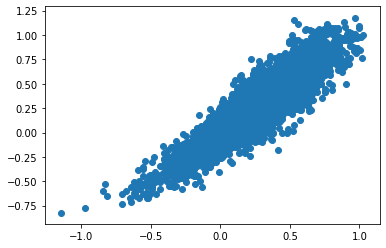

In [139]:
plt.scatter(lasso_lr.fittedvalues, y)
plt.show()

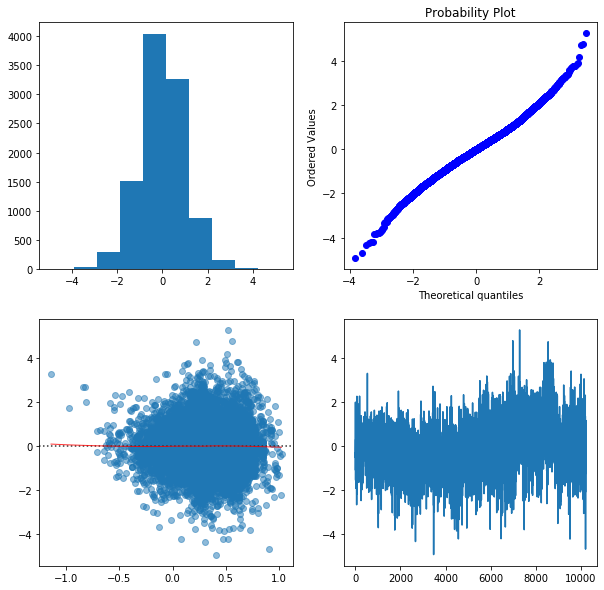

In [141]:
Model_Diagnostic(data = X, model = lasso_lr, date = train['Date'])

In [142]:
SSE = np.sum((np.exp(y) - np.exp(lasso_lr.fittedvalues))**2)
SST = np.sum((np.exp(y) - np.mean(np.exp(y)))**2)
1-(SSE/(X.shape[0] - X.shape[1] - 1))/(SST/(X.shape[0] - 1))

0.7311472877961908

## Forward Selection

Not feasible as there are too many predictors

In [143]:
def forward_selection(X, y, criteria = 'pvalue', validate_X = None, validate_y = None, alpha = 0.05, metric = 'adj_r2'):
    if criteria == 'pvalue':
        selected_list = []
        remaining_list = X.columns.tolist().copy()
        ssr_min = np.inf
        selected = None
        p_value = None
        for i in range(X.shape[1]):
            for col in remaining_list:
                cols = selected_list.copy()
                cols.append(col)
                lm = sm.OLS(y, sm.add_constant(X[cols])).fit()
                if ssr_min > lm.ssr:
                    ssr_min = lm.ssr
                    selected = col
                    p_value = lm.pvalues[col]
            
            if p_value < alpha:
                selected_list.append(selected)
                remaining_list.remove(selected)
                
            else:
                return selected_list
                
        return selected_list
    
    if criteria == 'metrics':
        selected_list = []
        remaining_list = X.columns.tolist().copy()
        ssr_min = np.inf
        selected = None
        if metric == 'adj_r2':
            prev_value = -np.inf
        else:
            prev_value = np.inf
        curr_value = None
        for i in range(X.shape[1]):
            for col in remaining_list:
                cols = selected_list.copy()
                cols.append(col)
                lm = sm.OLS(y, sm.add_constant(X[cols])).fit()
                if ssr_min > lm.ssr:
                    ssr_min = lm.ssr
                    selected = col
                    if metric == 'adj_r2':
                        curr_value = lm.rsquared_adj
                    elif metric == 'aic':
                        curr_value = lm.aic
                    elif metric == 'bic':
                        curr_value = lm.bic
                    else:
                        print('No such metric')
                        return
                    
            if metric == 'adj_r2':
                if prev_value < curr_value:
                    selected_list.append(selected)
                    remaining_list.remove(selected)
                    prev_value = curr_value
                else:
                    return selected_list
            
            else:
                if prev_value > curr_value:
                    selected_list.append(selected)
                    remaining_list.remove(selected)
                    prev_value = curr_value
                else:
                    return selected_list
                
        return selected_list
    
    if criteria == 'validate':
        selected_list = []
        remaining_list = X.columns.tolist().copy()
        ssr_min = np.inf
        selected = None
        prev_mse = np.inf
        curr_mse = None
        for i in range(X.shape[1]):
            for col in remaining_list:
                cols = selected_list.copy()
                cols.append(col)
                lm = sm.OLS(y, sm.add_constant(X[cols])).fit()
                if ssr_min > lm.ssr:
                    ssr_min = lm.ssr
                    selected = col
                    p_value = lm.pvalues[col]
            
            cols = selected_list.copy()
            cols.append(selected)
            lm = sm.OLS(y, sm.add_constant(X[cols])).fit()
            curr_mse = mean_squared_error(validate_y, lm.predict(sm.add_constant(validate_X[cols])))
            if prev_mse > curr_mse:
                selected_list.append(selected)
                remaining_list.remove(selected)
                prev_mse = curr_mse
                
            else:
                return selected_list
                
        return selected_list       

In [144]:
def data_preprocessing(data, regions = regions):
    X = data[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]
    y = data['AveragePrice']

    y = np.log(y)
    y = y.rename('log_AveragePrice', axis = 1)
    
    X = X.rename(columns = {'Small Bags': 'Small_Bags',
                            'Large Bags': 'Large_Bags',
                            'XLarge Bags': 'XLarge_Bags'})

    df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
    X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

    df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
    df = df[regions]
    X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

    X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
                   'Summer' if (x == 6 or x == 7 or x == 8) else
                   'Autumn' if (x == 9 or x == 10 or x == 11) else
                   'Winter' for x in pd.DatetimeIndex(X['Date']).month]
    X = X.drop('Date', axis = 1)

    df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
    X = pd.concat([X, df], axis = 1).drop('season', axis = 1)

    X['4046_organic'] = X['4046'] * X['organic']
    X['4225_organic'] = X['4225'] * X['organic']
    X['4770_organic'] = X['4770'] * X['organic']

    X['Small_Bags_organic'] = X['Small_Bags'] * X['organic']
    X['Large_Bags_organic'] = X['Large_Bags'] * X['organic']
    X['XLarge_Bags_organic'] = X['XLarge_Bags'] * X['organic']

    for season in ['Spring', 'Summer', 'Autumn']:
        col_name = '4046' + '_' + season
        X[col_name] = X['4046'] * X[season]
        col_name = '4225' + '_' + season
        X[col_name] = X['4225'] * X[season]        
        col_name = '4770' + '_' + season
        X[col_name] = X['4770'] * X[season]

        col_name = 'Small_Bags' + '_' + season
        X[col_name] = X['Small_Bags'] * X[season]  
        col_name = 'Large_Bags' + '_' + season
        X[col_name] = X['Large_Bags'] * X[season]
        col_name = 'XLarge_Bags' + '_' + season
        X[col_name] = X['XLarge_Bags'] * X[season]

        col_name = 'organic' + '_' + season
        X[col_name] = X['organic'] * X[season]

        col_name = '4046' + '_' + 'organic' + '_' + season
        X[col_name] = X['4046'] * X['organic'] * X[season]
        col_name = '4225' + '_' + 'organic' + '_' + season
        X[col_name] = X['4225'] * X['organic'] * X[season]
        col_name = '4770' + '_' + 'organic' + '_' + season
        X[col_name] = X['4770'] * X['organic'] * X[season] 

        col_name = 'Small_Bags' + '_' + 'organic' + '_' + season
        X[col_name] = X['Small_Bags'] * X['organic'] * X[season]
        col_name = 'Large_Bags' + '_' + 'organic' + '_' + season
        X[col_name] = X['Large_Bags'] * X['organic'] * X[season]
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + season
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[season]         

    for region in regions:
        col_name = '4046' + '_' + region
        X[col_name] = X['4046'] * X[region]   
        col_name = '4225' + '_' + region
        X[col_name] = X['4225'] * X[region]   
        col_name = '4770' + '_' + region
        X[col_name] = X['4770'] * X[region]

        col_name = 'Small_Bags' + '_' + region
        X[col_name] = X['Small_Bags'] * X[region]
        col_name = 'Large_Bags' + '_' + region
        X[col_name] = X['Large_Bags'] * X[region]
        col_name = 'XLarge_Bags' + '_' + region        
        X[col_name] = X['XLarge_Bags'] * X[region]

        col_name = 'organic' + '_' + region
        X[col_name] = X['organic'] * X[region]

        col_name = '4046' + '_' + 'organic' + '_' + region
        X[col_name] = X['4046'] * X['organic'] * X[region]
        col_name = '4225' + '_' + 'organic' + '_' + region
        X[col_name] = X['4225'] * X['organic'] * X[region]
        col_name = '4770' + '_' + 'organic' + '_' + region
        X[col_name] = X['4770'] * X['organic'] * X[region]

        col_name = 'Small_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Small_Bags'] * X['organic'] * X[region]
        col_name = 'Large_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Large_Bags'] * X['organic'] * X[region] 
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] 

        for season in ['Spring', 'Summer', 'Autumn']:
            col_name = region + '_' + season
            X[col_name] = X[region] * X[season]

            col_name = '4046' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X[region] * X[season]
            col_name = '4225' + '_' + region + '_' + season
            X[col_name] = X['4225'] * X[region] * X[season] 
            col_name = '4770' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X[region] * X[season]

            col_name = 'Small_Bags' + '_' + region + '_' + season
            X[col_name] = X['Small_Bags'] * X[region] * X[season]
            col_name = 'Large_Bags' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X[region] * X[season]
            col_name = 'XLarge_Bags' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X[region] * X[season]

            col_name = 'organic' + '_' + region + '_' + season
            X[col_name] = X['organic'] * X[region] * X[season]
            col_name = '4046' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X['organic'] * X[region] * X[season]
            col_name = '4225' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4225'] * X['organic'] * X[region] * X[season] 
            col_name = '4770' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X['organic'] * X[region] * X[season]  

            col_name = 'Small_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Small_Bags'] * X['organic'] * X[region] * X[season]
            col_name = 'Large_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X['organic'] * X[region] * X[season]
            col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] * X[season]  

    return (X, y)

In [145]:
validate_X, validate_y = data_preprocessing(validate)

In [146]:
print('Final Model:', mean_squared_error(validate_y, full_model.predict(sm.add_constant(validate_X.drop(XLarge_Bags_type_season+XLarge_Bags_type_region_season, axis = 1)))))

Final Model: 0.027509695372504264


In [147]:
print('Model without XLarge Bagsxtypexregion:', mean_squared_error(validate_y, XLarge_Bags_type_region_model.predict(sm.add_constant(validate_X.drop(XLarge_Bags_type_region+XLarge_Bags_type_region_season, axis = 1)))))
print('Model without XLarge Bagsxtypexseason:', mean_squared_error(validate_y, XLarge_Bags_type_season_model.predict(sm.add_constant(validate_X.drop(XLarge_Bags_type_season+XLarge_Bags_type_region_season, axis = 1)))))
print('Model without typexregionxseason:', mean_squared_error(validate_y, type_region_season_model.predict(sm.add_constant(validate_X.drop(type_region_season+XLarge_Bags_type_region_season, axis = 1)))))

Model without XLarge Bagsxtypexregion: 0.02742640195836649
Model without XLarge Bagsxtypexseason: 0.027509695372504264
Model without typexregionxseason: 0.02559049997143025


In [148]:
print('Model without 4 way interaction effects:', mean_squared_error(validate_y, reduced_4_way_model.predict(sm.add_constant(validate_X.drop(reduced_4_way, axis = 1)))))
print('')
print('Model without Small Volumextypexregionxseason:', mean_squared_error(validate_y, Small_Volume_type_region_season_model.predict(sm.add_constant(validate_X.drop(Small_Volume_type_region_season, axis = 1)))))
print('Model without Intermediate Volumextypexregionxseason:', mean_squared_error(validate_y, Intermediate_Volume_type_region_season_model.predict(sm.add_constant(validate_X.drop(Intermediate_Volume_type_region_season, axis = 1)))))
print('Model without Large Volumextypexregionxseason:', mean_squared_error(validate_y, Large_Volume_type_region_season_model.predict(sm.add_constant(validate_X.drop(Large_Volume_type_region_season, axis = 1)))))
print('')
print('Model without Small Bagsxtypexregionxseason:', mean_squared_error(validate_y, Small_Bags_type_region_season_model.predict(sm.add_constant(validate_X.drop(Small_Bags_type_region_season, axis = 1)))))
print('Model without Large Bagsxtypexregionxseason:', mean_squared_error(validate_y, Large_Bags_type_region_season_model.predict(sm.add_constant(validate_X.drop(Large_Bags_type_region_season, axis = 1)))))
print('Model without XLarge Bagsxtypexregionxseason:', mean_squared_error(validate_y, XLarge_Bags_type_region_season_model.predict(sm.add_constant(validate_X.drop(XLarge_Bags_type_region_season, axis = 1)))))
# There is contrast between ANOVA and mse. It maybe because of collinearity and unequal variance.

Model without 4 way interaction effects: 0.022020106328478704

Model without Small Volumextypexregionxseason: 0.026430168620610896
Model without Intermediate Volumextypexregionxseason: 0.02586060975036112
Model without Large Volumextypexregionxseason: 0.024650262271305578

Model without Small Bagsxtypexregionxseason: 0.0274725101722143
Model without Large Bagsxtypexregionxseason: 0.024075043331071553
Model without XLarge Bagsxtypexregionxseason: 0.027468973714227043


In [149]:
print('Ridge:', mean_squared_error(validate_y, ridge.predict(validate_X)))
print('Lasso:', mean_squared_error(validate_y, lasso.predict(validate_X)))

Ridge: 0.023852914046547633
Lasso: 0.019061316113414717


In [150]:
test_X, test_y = data_preprocessing(test)

In [151]:
print('Train data:', mean_squared_error(y, lasso.predict(X)))
print('Validate data:', mean_squared_error(validate_y, lasso.predict(validate_X)))
print('Test data:', mean_squared_error(test_y, lasso.predict(test_X)))
# Consistence

Train data: 0.01643240761341976
Validate data: 0.019061316113414717
Test data: 0.01925862582123154


In [152]:
print('Train data:', mean_squared_error(y, lasso_lr.predict(sm.add_constant(X[lasso_predictors]))))
print('Validate data:', mean_squared_error(validate_y, lasso_lr.predict(sm.add_constant(validate_X[lasso_predictors]))))
print('Test data:', mean_squared_error(test_y, lasso_lr.predict(sm.add_constant(test_X[lasso_predictors]))))

Train data: 0.013552221230489986
Validate data: 0.020674904122297368
Test data: 0.017244033215108097


# Model Evaluation

In [153]:
X, y = data_preprocessing(data, regions)

In [154]:
lasso_cv = LassoCV(cv = 5, normalize = True).fit(X, y)
lasso_cv.alpha_

5.728326617380188e-05

In [155]:
lasso = Lasso(alpha = lasso_cv.alpha_, normalize = True).fit(X, y)

In [156]:
lasso_predictors = X.columns[np.where(lasso.coef_!=0)]

model = sm.OLS(y, sm.add_constant(X[lasso_predictors])).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       log_AveragePrice   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     398.8
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        11:06:37   Log-Likelihood:                 8938.9
No. Observations:               18249   AIC:                        -1.762e+04
Df Residuals:                   18120   BIC:                        -1.661e+04
Df Model:                         128                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.1466      0.003     49.367      0.000       0.141       0.152
4046                                 1.467e-10    1.7e-09      0.086      0.931   -3.18e-09    3.48e-09
4770                                -1.719e-07   1.94e-08     -8.868      0.000    -2.1e-07   -1.34e-07
organic                                 0.3109      0.003     88.827      0.000       0.304       0.318
Albany                                  0.0565      0.009      6.329      0.000       0.039       0.074
BaltimoreWashington                     0.0266      0.012      2.192      0.028       0.003       0.050
Boston                                 -0.0648      0.014     -4.710      0.000      -0.092      -0.038
Charlotte                               0.0375      0.012      3.188      0.001       0.014       0.060
Chicago                                 0.0387      0.009      4.099      0.000       0.020       0.057
CincinnatiDayton                       -0.0225      0.014     -1.553      0.120      -0.051       0.006
DallasFtWorth                          -0.2286      0.012    -19.627      0.000      -0.251      -0.206
Denver                                 -0.0210      0.016     -1.319      0.187      -0.052       0.010
HartfordSpringfield                     0.1330      0.012     11.314      0.000       0.110       0.156
Houston                                -0.1767      0.017    -10.677      0.000      -0.209      -0.144
LosAngeles                             -0.0137      0.018     -0.742      0.458      -0.050       0.022
NewOrleansMobile                       -0.0748      0.011     -6.635      0.000      -0.097      -0.053
NewYork                                 0.0855      0.013      6.427      0.000       0.059       0.112
Northeast                               0.1045      0.008     12.582      0.000       0.088       0.121
Philadelphia                            0.1184      0.008     14.242      0.000       0.102       0.135
RichmondNorfolk                        -0.0165      0.013     -1.288      0.198      -0.042       0.009
Roanoke                                -0.0836      0.010     -8.719      0.000      -0.102      -0.065
Sacramento                              0.0325      0.012      2.764      0.006       0.009       0.055
SanFrancisco                            0.0985      0.013      7.837      0.000       0.074       0.123
SouthCentral                           -0.2170      0.012    -18.663      0.000      -0.240      -0.194
Autumn                                  0.1298      0.003     46.382      0.000       0.124       0.135
Summer                                  0.0905      0.004     23.543      0.000       0.083       0.098
Large_Bags_organic                   -5.94e-07   6.68e-08     -8.88

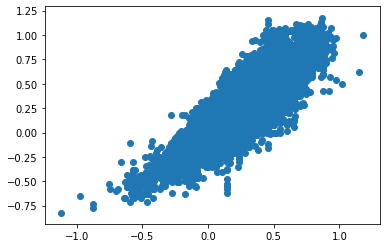

In [157]:
plt.scatter(model.fittedvalues, y)
plt.show()

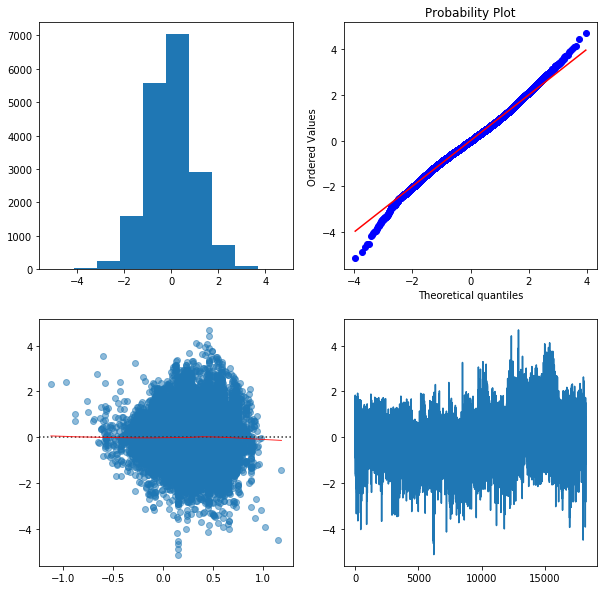

In [159]:
Model_Diagnostic(data = X, model = model, date = data['Date'])

In [163]:
vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X[lasso_predictors]).values, i) for i in range(X[lasso_predictors].shape[1] + 1)]
vif['feature'] = sm.add_constant(X[lasso_predictors]).columns
vif.drop(0).sort_values('vif', ascending = False)
# Not too large from 10

vif                          feature
53   12.725509               4046_DallasFtWorth
54   12.030035               4225_DallasFtWorth
113  10.733420                4046_SouthCentral
114  10.051379                4225_SouthCentral
105   8.996616                    4225_SanDiego
..         ...                              ...
71    1.014657  Large_Bags_organic_Indianapolis
62    1.014436       Large_Bags_organic_Detroit
84    1.013830    Large_Bags_organic_Louisville
91    1.012303    Large_Bags_NorthernNewEngland
64    1.010139   Small_Bags_organic_GrandRapids

[128 rows x 2 columns]

In [160]:
SSE = np.sum((np.exp(y) - np.exp(model.fittedvalues))**2)
SST = np.sum((np.exp(y) - np.mean(np.exp(y)))**2)
1-(SSE/(X.shape[0] - X.shape[1] - 1))/(SST/(X.shape[0] - 1))

0.6419961755433745

In [161]:
np.sqrt(SSE/(X.shape[0] - X.shape[1] - 1))

0.2409351579104576

In [162]:
np.mean(data['AveragePrice'])

1.405978409775878

# Conclusion

1. Our model can explain about 85% variation of the average price. Also, the RMSE is 0.241 which is small compare to the mean of the average prices. The performance is good.  
2. Although there is severe heteroscedasticity problem, the estimated coefficients are still reliable. For example, in the winter in Harrisburg Scranton, 10,000,000 units increase in the sales of avocadoes with size 4047 will approximately increase the average price by 1.719% on average, holding other factors constant (other size of bags and the sales of avocado with different size) .

# Problems

1. There is heteroscedasticity as the points in the middle value of predicted y are more widely spread. We also cannot interpret the confidence interval and prediction interval. The result from ANOVA is not reliable.
2. The performance of the model is a bit inconsistence.

# Further Work

1. Possible transformation:  
    1.1 We can see that the variance is not constant. Therefore, we can try Box-Cox transformation to stabilize the variance. However, it may suggest some meaningless transformation.   
    1.2 We can also try using spline to transform the continuous variables since we cannot apply log transformation when there are 0 in the variables. Also, the transformation may not be interpretable or overfit to the training data.
2. Time series model:  
    2.1 As the average price is increasing from time, we can try to construct time series model so as to fit the pattern better (ARIMAX etc.).